In [3]:
from dask.distributed import Client, LocalCluster
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

# Loans: Data Review
***
Data review, quality, and cleansing



In [26]:
cluster = LocalCluster()
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 15.83 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:53309,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 15.83 GiB
Comm: tcp://127.0.0.1:53334,Total threads: 2
Dashboard: http://127.0.0.1:53341/status,Memory: 3.96 GiB
Nanny: tcp://127.0.0.1:53312,


# 1) Summary Statement
  * Short and sweet

# 2) Dask
  * What is it?
  * Why use it?



# The Data
https://www.kaggle.com/datasets/meastanmay/nbfi-vehicle-loan-repayment-dataset?select=Test_Dataset.csv

In [3]:
data_dict = pd.read_csv("data/DataDictTypes.csv")
data_dict.head(50)

,Column,Description,VariableType,Dtype
0,ID,Client Loan application ID,ID,object
1,Client_Income,Client Income in $,Continuous,float64
2,Car_Owned,Any Car owned by client before applying for th...,Categorical (Binary),object
3,Bike_Owned,Any bike owned by client (0 means No and 1 mea...,Categorical (Binary),object
4,Active_Loan,Any other active loan at the time of aplicatio...,Categorical (Binary),object
5,House_Own,Any house owned by client (0 means No and 1 me...,Categorical (Binary),object
6,Child_Count,Number of children the client has,Discrete,float64
7,Credit_Amount,Credit amount of the loan in $,Continuous,float64
8,Loan_Annuity,Loan annuity in $,Continuous,float64
9,Accompany_Client,Who accompanied the client when client applied...,Categorical (String - Nominal),object


# Read data
***
When reading data, Dask attempts to infer the data types by taking a sample from the beginning of the file. While allowing Dask to infer the datatypes can be convenient, there is a multitude of reasons why we should explicitly define the datatypes upon reading the data.

**Numeric representation of categorical variables:** There may be binary or numeric indicators that represent categorical data or factor levels.  I would like to set all categorical data as object type, so I can easily identify qualitative fields and ensure that we are not performing any numerical computations on the fields that would inappropriate for categorical data.

**Mixed Datatype Inference Errors:** There may be mixed datatypes in a column that could raise ValueErrors when reading the data. If there is a conflict between the data presented at the end of the file and the sample used to infer datatypes, Dask will throw an error when reading the data. For example, if we attempt to read the loans dataset without specifying the datatypes, we will receive several value errors. For example, Age_Days is inferred to be a float, because it's an integer value with nulls. Since nulls are float values Dask makes the inference. However, outside the inference sample, Dask encounters a character value and throws a value error.  This inference error does occur when reading the following fields in the data:

 * Age_Days: ValueError("could not convert string to float: 'x'")
 * Client_Income: ValueError("invalid literal for int() with base 10: '32480.55'")
 * Credit_Amount: ValueError("could not convert string to float: '$'") \
 * Loan_Annuity: ValueError("could not convert string to float: '$'")
 * Population_Region_Relative: ValueError("could not convert string to float: '@'")
 * Registration_Days: ValueError("could not convert string to float: 'x'")
 * Score_Source_3: ValueError("could not convert string to float: '&'")

Another example of data type inference errors can occur when a column is populated with integer types in the inference sample but later has nulls. Since nulls are of float type, we will receive a value error.
 * ID_Days: ValueError('cannot convert float NaN to integer')
 * Employed_Days: ValueError('cannot convert float NaN to integer')



To address the above value errors, there fields will need to be read in as `object` and later cleaned.

In [4]:
dtype_dict = {
    'ID': 'object',
    'Client_Income':'object',
    'Car_Owned': 'object',
    'Bike_Owned': 'object',
    'Active_Loan': 'object',
    'House_Own': 'object',
    'Child_Count': 'float64',
    'Credit_Amount': 'object',
    'Loan_Annuity': 'object',
    'Accompany_Client': 'object',
    'Client_Income_Type': 'object',
    'Client_Education': 'object',
    'Client_Marital_Status': 'object',
    'Client_Gender': 'object',
    'Loan_Contract_Type': 'object',
    'Client_Housing_Type': 'object',
    'Population_Region_Relative': 'object',
    'Age_Days': 'object',
    'Employed_Days': 'object',
    'Registration_Days': 'object',
    'ID_Days': 'object',
    'Own_House_Age': 'float64',
    'Mobile_Tag': 'object',
    'Homephone_Tag': 'object',
    'Workphone_Working': 'object',
    'Client_Occupation': 'object',
    'Client_Family_Members': 'float64',
    'Cleint_City_Rating': 'object',
    'Application_Process_Day': 'object',
    'Application_Process_Hour': 'object',
    'Client_Permanent_Match_Tag': 'object',
    'Client_Contact_Work_Tag': 'object',
    'Type_Organization': 'object',
    'Score_Source_1': 'float64',
    'Score_Source_2': 'float64',
    'Score_Source_3': 'object',
    'Social_Circle_Default': 'float64',
    'Phone_Change': 'float64',
    'Credit_Bureau': 'float64',
    'Default':'object'
}

# Read training data
df = dd.read_csv("data/Train_Dataset.csv", dtype=dtype_dict)
print(df.columns)
df.head()

Index(['ID', 'Client_Income', 'Car_Owned', 'Bike_Owned', 'Active_Loan',
       'House_Own', 'Child_Count', 'Credit_Amount', 'Loan_Annuity',
       'Accompany_Client', 'Client_Income_Type', 'Client_Education',
       'Client_Marital_Status', 'Client_Gender', 'Loan_Contract_Type',
       'Client_Housing_Type', 'Population_Region_Relative', 'Age_Days',
       'Employed_Days', 'Registration_Days', 'ID_Days', 'Own_House_Age',
       'Mobile_Tag', 'Homephone_Tag', 'Workphone_Working', 'Client_Occupation',
       'Client_Family_Members', 'Cleint_City_Rating',
       'Application_Process_Day', 'Application_Process_Hour',
       'Client_Permanent_Match_Tag', 'Client_Contact_Work_Tag',
       'Type_Organization', 'Score_Source_1', 'Score_Source_2',
       'Score_Source_3', 'Social_Circle_Default', 'Phone_Change',
       'Credit_Bureau', 'Default'],
      dtype='object')


,ID,Client_Income,Car_Owned,Bike_Owned,Active_Loan,House_Own,Child_Count,Credit_Amount,Loan_Annuity,Accompany_Client,Client_Income_Type,Client_Education,Client_Marital_Status,Client_Gender,Loan_Contract_Type,Client_Housing_Type,Population_Region_Relative,Age_Days,Employed_Days,Registration_Days,ID_Days,Own_House_Age,Mobile_Tag,Homephone_Tag,Workphone_Working,Client_Occupation,Client_Family_Members,Cleint_City_Rating,Application_Process_Day,Application_Process_Hour,Client_Permanent_Match_Tag,Client_Contact_Work_Tag,Type_Organization,Score_Source_1,Score_Source_2,Score_Source_3,Social_Circle_Default,Phone_Change,Credit_Bureau,Default
0,12142509,6750,0,0,1,0,0.0,61190.55,3416.85,Alone,Commercial,Secondary,M,Male,CL,Home,0.028663,13957,1062,6123,383,NaN,1,1,0,Sales,2.0,2,6,17,Yes,Yes,Self-employed,0.568066,0.478787,NaN,0.0186,63.0,NaN,0
1,12138936,20250,1,0,1,NaN,0.0,15282,1826.55,Alone,Service,Graduation,M,Male,CL,Home,0.008575,14162,4129,7833,21,0.0,1,0,1,NaN,2.0,2,3,10,Yes,Yes,Government,0.563360,0.215068,NaN,NaN,NaN,NaN,0
2,12181264,18000,0,0,1,0,1.0,59527.35,2788.2,Alone,Service,Graduation dropout,W,Male,CL,Family,0.0228,16790,5102,NaN,331,NaN,1,0,0,Realty agents,2.0,2,4,NaN,Yes,Yes,Self-employed,NaN,0.552795,0.329655054,0.0742,277.0,0.0,0
3,12188929,15750,0,0,1,1,0.0,53870.4,2295.45,Alone,Retired,Secondary,M,Male,CL,Home,0.010556,23195,365243,NaN,775,NaN,1,0,0,NaN,2.0,3,2,15,Yes,Yes,XNA,NaN,0.135182,0.631354537,NaN,1700.0,3.0,0
4,12133385,33750,1,0,1,0,2.0,133988.4,3547.35,Alone,Commercial,Secondary,M,Female,CL,Home,0.020713,11366,2977,5516,4043,6.0,1,0,0,Laborers,4.0,1,3,NaN,Yes,Yes,Business Entity Type 3,0.508199,0.301182,0.355638717,0.2021,674.0,1.0,0


In [5]:
def strip_chars_from_number(dframe):
    """ Remove embedded non-numeric characters from numeric values
        and convert to float.
    """
    strip_char_cols = [
        'Client_Income',
        'Credit_Amount',
        'Loan_Annuity',
        'Population_Region_Relative',
        'Age_Days',
        'Employed_Days',
        'Registration_Days',
        'ID_Days',
        'Score_Source_3'
    ]
    for col in strip_char_cols:
        # dframe[col] = dframe[col].str.extract('(\d+)', expand=False) #.astype(float)
        dframe[col] = dframe[col].str.extract("(\d*\.\d+|\d+)", expand=False).astype(float)
    return dframe
        
df = df.map_partitions(strip_chars_from_number)
display(df.dtypes)
df.head(20)

ID                             object
Client_Income                 float64
Car_Owned                      object
Bike_Owned                     object
Active_Loan                    object
House_Own                      object
Child_Count                   float64
Credit_Amount                 float64
Loan_Annuity                  float64
Accompany_Client               object
Client_Income_Type             object
Client_Education               object
Client_Marital_Status          object
Client_Gender                  object
Loan_Contract_Type             object
Client_Housing_Type            object
Population_Region_Relative    float64
Age_Days                      float64
Employed_Days                 float64
Registration_Days             float64
ID_Days                       float64
Own_House_Age                 float64
Mobile_Tag                     object
Homephone_Tag                  object
Workphone_Working              object
Client_Occupation              object
Client_Famil

,ID,Client_Income,Car_Owned,Bike_Owned,Active_Loan,House_Own,Child_Count,Credit_Amount,Loan_Annuity,Accompany_Client,Client_Income_Type,Client_Education,Client_Marital_Status,Client_Gender,Loan_Contract_Type,Client_Housing_Type,Population_Region_Relative,Age_Days,Employed_Days,Registration_Days,ID_Days,Own_House_Age,Mobile_Tag,Homephone_Tag,Workphone_Working,Client_Occupation,Client_Family_Members,Cleint_City_Rating,Application_Process_Day,Application_Process_Hour,Client_Permanent_Match_Tag,Client_Contact_Work_Tag,Type_Organization,Score_Source_1,Score_Source_2,Score_Source_3,Social_Circle_Default,Phone_Change,Credit_Bureau,Default
0,12142509,6750.0,0,0,1,0,0.0,61190.55,3416.85,Alone,Commercial,Secondary,M,Male,CL,Home,0.028663,13957.0,1062.0,6123.0,383.0,NaN,1,1,0,Sales,2.0,2,6,17,Yes,Yes,Self-employed,0.568066,0.478787,NaN,0.0186,63.0,NaN,0
1,12138936,20250.0,1,0,1,NaN,0.0,15282.00,1826.55,Alone,Service,Graduation,M,Male,CL,Home,0.008575,14162.0,4129.0,7833.0,21.0,0.0,1,0,1,NaN,2.0,2,3,10,Yes,Yes,Government,0.563360,0.215068,NaN,NaN,NaN,NaN,0
2,12181264,18000.0,0,0,1,0,1.0,59527.35,2788.20,Alone,Service,Graduation dropout,W,Male,CL,Family,0.022800,16790.0,5102.0,NaN,331.0,NaN,1,0,0,Realty agents,2.0,2,4,NaN,Yes,Yes,Self-employed,NaN,0.552795,0.329655,0.0742,277.0,0.0,0
3,12188929,15750.0,0,0,1,1,0.0,53870.40,2295.45,Alone,Retired,Secondary,M,Male,CL,Home,0.010556,23195.0,365243.0,NaN,775.0,NaN,1,0,0,NaN,2.0,3,2,15,Yes,Yes,XNA,NaN,0.135182,0.631355,NaN,1700.0,3.0,0
4,12133385,33750.0,1,0,1,0,2.0,133988.40,3547.35,Alone,Commercial,Secondary,M,Female,CL,Home,0.020713,11366.0,2977.0,5516.0,4043.0,6.0,1,0,0,Laborers,4.0,1,3,NaN,Yes,Yes,Business Entity Type 3,0.508199,0.301182,0.355639,0.2021,674.0,1.0,0
5,12191614,11250.0,0,1,1,1,1.0,13752.00,653.85,Alone,Service,Secondary,W,Female,CL,Home,0.019101,13881.0,1184.0,3910.0,3910.0,NaN,1,0,0,Laborers,2.0,2,2,10,Yes,Yes,Other,NaN,0.697928,0.420611,0.0639,739.0,0.0,0
6,12128086,15750.0,1,1,0,1,0.0,128835.00,3779.55,Alone,Retired,Secondary,S,Male,CL,Home,0.016612,21323.0,365243.0,113.0,4855.0,10.0,1,0,0,NaN,1.0,2,3,14,Yes,Yes,XNA,0.729913,0.602545,0.511892,0.2041,0.0,3.0,0
7,12215264,13500.0,0,0,1,1,0.0,60415.20,3097.80,Alone,Retired,Secondary,M,Male,CL,Home,0.009175,22493.0,365243.0,12617.0,5280.0,NaN,1,0,1,NaN,2.0,2,4,15,Yes,Yes,XNA,0.711468,0.657508,0.549597,NaN,1687.0,4.0,0
8,12159147,13500.0,1,1,0,1,1.0,45000.00,1200.15,Relative,Commercial,Graduation,M,Female,CL,Home,0.006008,NaN,7889.0,5455.0,2665.0,14.0,1,0,1,Sales,3.0,2,4,13,Yes,Yes,Self-employed,0.475727,0.637594,0.553165,0.1670,1611.0,0.0,0
9,12130547,12150.0,0,0,0,1,0.0,16320.15,1294.65,Alone,Retired,Secondary,W,Male,CL,Home,0.016612,20507.0,365243.0,2834.0,4053.0,NaN,1,0,0,NaN,1.0,2,NaN,9,Yes,Yes,XNA,0.682285,0.063343,0.080650,NaN,533.0,5.0,0


# EDA
## Rows and Class Distribution

Row counts:  121856


Class Distribution:


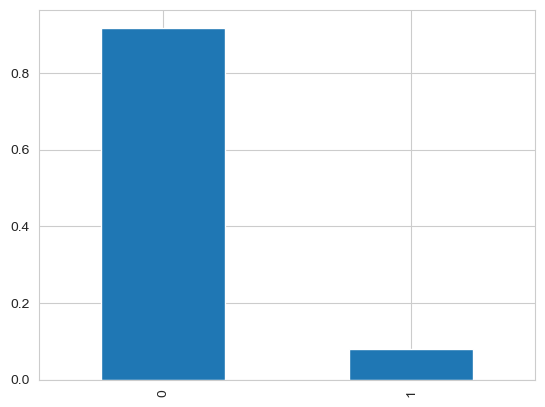

0    0.919208
1    0.080792
Name: Default, dtype: float64


0    112011
1      9845
Name: Default, dtype: int64

In [6]:
from matplotlib import pyplot as plt
import seaborn as sns

n_rows = len(df)
print("Row counts: ", n_rows)
print("\n")
print("Class Distribution:")
classes = df.Default.value_counts().compute() / n_rows
classes.plot(kind='bar')
plt.show()
print(classes)
df.Default.value_counts().compute()

## Univariate Stats
Like the pandas API, we can use the describe function to view a summary of univariate descriptive statistics.  Reviewing the statistics early in the process can help identify potential data quality issues. For example, we can see the below possible outlier and data collection issues:

•	**Child count:** 19 children is the max?
•	**Credit Amount:** The loans are supposed to be for car loans, yet 23 have an observation with $405,000.
•	**Population_Region_Relative:** The metric should be on a 0 -1 scale, but the max value is 100.
•	**Client Family Members:** Outlier research should be conducted
•	**Score_Source_2:**  Should be on a scale from 0-1. There are values of 100.
•	**Credit_Bureau:** Outlier Values should be inspected.
•	**Employed Days:** Outlier Values should be inspected.
•	**Population Relative:** Extreme value appears to be systematic.

In [7]:
stats = df.describe().compute()
stats

,Client_Income,Child_Count,Credit_Amount,Loan_Annuity,Population_Region_Relative,Age_Days,Employed_Days,Registration_Days,ID_Days,Own_House_Age,Client_Family_Members,Score_Source_1,Score_Source_2,Score_Source_3,Social_Circle_Default,Phone_Change,Credit_Bureau
count,1.182340e+05,118218.000000,118219.000000,117030.000000,116988.000000,118239.000000,118190.000000,118225.000000,115871.000000,41761.000000,119446.000000,53021.000000,116170.000000,94934.000000,59928.000000,118192.000000,103316.000000
mean,1.686519e+04,0.417779,60046.488951,2721.254492,0.022602,16027.422948,67154.070615,4975.162123,2987.471015,12.157324,2.154329,0.501213,0.518625,0.511180,0.117428,962.106056,1.891082
std,1.153815e+04,0.728802,40350.663346,1461.466162,0.413617,4366.356504,138971.782951,3514.546963,1511.884576,12.056079,0.912686,0.211204,0.740248,0.194333,0.107974,827.976726,1.861921
min,2.565000e+03,0.000000,4500.000000,217.350000,0.000533,7676.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.014568,0.000005,0.000527,0.000000,0.000000,0.000000
25%,1.125000e+04,0.000000,27000.000000,1657.350000,0.010006,12398.000000,932.000000,2008.000000,1705.000000,5.000000,2.000000,0.333481,0.390164,0.372334,0.057700,272.000000,0.000000
50%,1.440000e+04,0.000000,51750.000000,2499.750000,0.018850,15734.000000,2212.000000,4493.000000,3242.000000,9.000000,2.000000,0.504657,0.564978,0.537070,0.088700,755.000000,1.000000
75%,2.025000e+04,1.000000,80865.000000,3466.800000,0.028663,19661.000000,5634.000000,7464.000000,4295.000000,15.000000,3.000000,0.673890,0.664011,0.667458,0.148500,1570.000000,3.000000
max,1.800009e+06,19.000000,405000.000000,22500.000000,100.000000,25201.000000,365243.000000,23738.000000,7197.000000,69.000000,16.000000,0.945741,100.000000,0.896010,1.000000,4185.000000,22.000000


In [8]:
df[df.Population_Region_Relative > .05].compute()

,ID,Client_Income,Car_Owned,Bike_Owned,Active_Loan,House_Own,Child_Count,Credit_Amount,Loan_Annuity,Accompany_Client,Client_Income_Type,Client_Education,Client_Marital_Status,Client_Gender,Loan_Contract_Type,Client_Housing_Type,Population_Region_Relative,Age_Days,Employed_Days,Registration_Days,ID_Days,Own_House_Age,Mobile_Tag,Homephone_Tag,Workphone_Working,Client_Occupation,Client_Family_Members,Cleint_City_Rating,Application_Process_Day,Application_Process_Hour,Client_Permanent_Match_Tag,Client_Contact_Work_Tag,Type_Organization,Score_Source_1,Score_Source_2,Score_Source_3,Social_Circle_Default,Phone_Change,Credit_Bureau,Default
36,12111337,35550.0,1,1,1,1,0.0,77968.80,3316.50,Alone,Service,Secondary,NaN,Male,CL,Home,0.072508,19758.0,212.0,5235.0,2980.0,16.0,1,1,1,Sales,1.0,1,1,19,Yes,Yes,Self-employed,0.619768,0.675417,NaN,NaN,378.0,5.0,0
44,12214917,22500.0,0,0,0,1,0.0,82567.35,3511.35,Relative,Retired,Secondary,M,Male,CL,Home,0.072508,NaN,365243.0,8578.0,1642.0,NaN,1,0,0,NaN,2.0,1,1,15,Yes,Yes,XNA,0.804383,0.536978,0.270707,0.0773,48.0,0.0,0
88,12122615,27000.0,0,0,1,1,1.0,52128.00,1998.45,Alone,Commercial,Graduation,M,Female,NaN,Family,0.072508,10574.0,1081.0,5437.0,1379.0,NaN,1,0,0,High skill tech,3.0,1,2,16,Yes,Yes,Other,NaN,0.759759,0.547810,0.1460,918.0,2.0,0
120,12152611,18000.0,1,0,0,1,2.0,131400.45,4355.55,Alone,Commercial,Secondary,M,Female,CL,Home,0.072508,15305.0,221.0,9395.0,114.0,3.0,1,0,1,NaN,4.0,1,3,14,Yes,Yes,Transport: type 4,NaN,0.660005,0.130947,0.4165,2088.0,0.0,0
134,12190348,54000.0,1,0,0,1,0.0,NaN,2250.00,Alone,Commercial,Graduation,M,Male,RL,Home,0.072508,9450.0,NaN,1736.0,2022.0,4.0,1,0,0,Core,2.0,1,1,15,Yes,Yes,Self-employed,NaN,0.754536,NaN,0.1423,155.0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121721,12195180,18000.0,0,0,1,1,0.0,33750.00,1687.50,Alone,Commercial,Secondary,M,Male,RL,NaN,0.072508,13213.0,2662.0,7147.0,1492.0,NaN,1,1,0,Sales,2.0,1,4,16,No,No,Business Entity Type 3,NaN,0.484148,0.159520,0.0746,335.0,2.0,0
121740,12205777,15750.0,0,0,0,1,0.0,76500.00,3825.00,Alone,Commercial,Secondary,M,Female,RL,Home,0.072508,19114.0,1201.0,11473.0,NaN,NaN,1,0,1,Laborers,2.0,1,5,16,Yes,Yes,Business Entity Type 1,0.803346,0.508535,0.750375,0.1237,44.0,0.0,0
121778,12186914,15750.0,1,1,0,1,0.0,47404.80,NaN,Alone,Commercial,Graduation,M,Female,CL,Home,0.072508,20780.0,3355.0,6478.0,NaN,9.0,1,0,1,NaN,2.0,1,6,13,Yes,Yes,Business Entity Type 3,NaN,0.700053,NaN,0.0485,423.0,NaN,0
121820,12183295,20250.0,0,1,1,0,0.0,67950.00,3620.25,Alone,Service,Secondary,M,Male,CL,Home,0.072508,18378.0,1048.0,8344.0,1941.0,NaN,1,0,1,Laborers,2.0,1,6,16,Yes,Yes,Government,0.796393,0.716137,0.565608,0.0897,2085.0,2.0,0


<Axes: xlabel='Population_Region_Relative'>

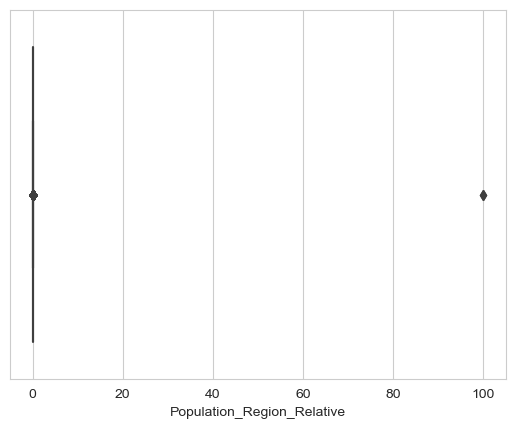

In [9]:
sns.boxplot(df[['Population_Region_Relative']].compute(), x='Population_Region_Relative')

In [10]:
df = df[df.Population_Region_Relative < .07]

## Null Values
Sorting not recommended. Can return results as cheap series

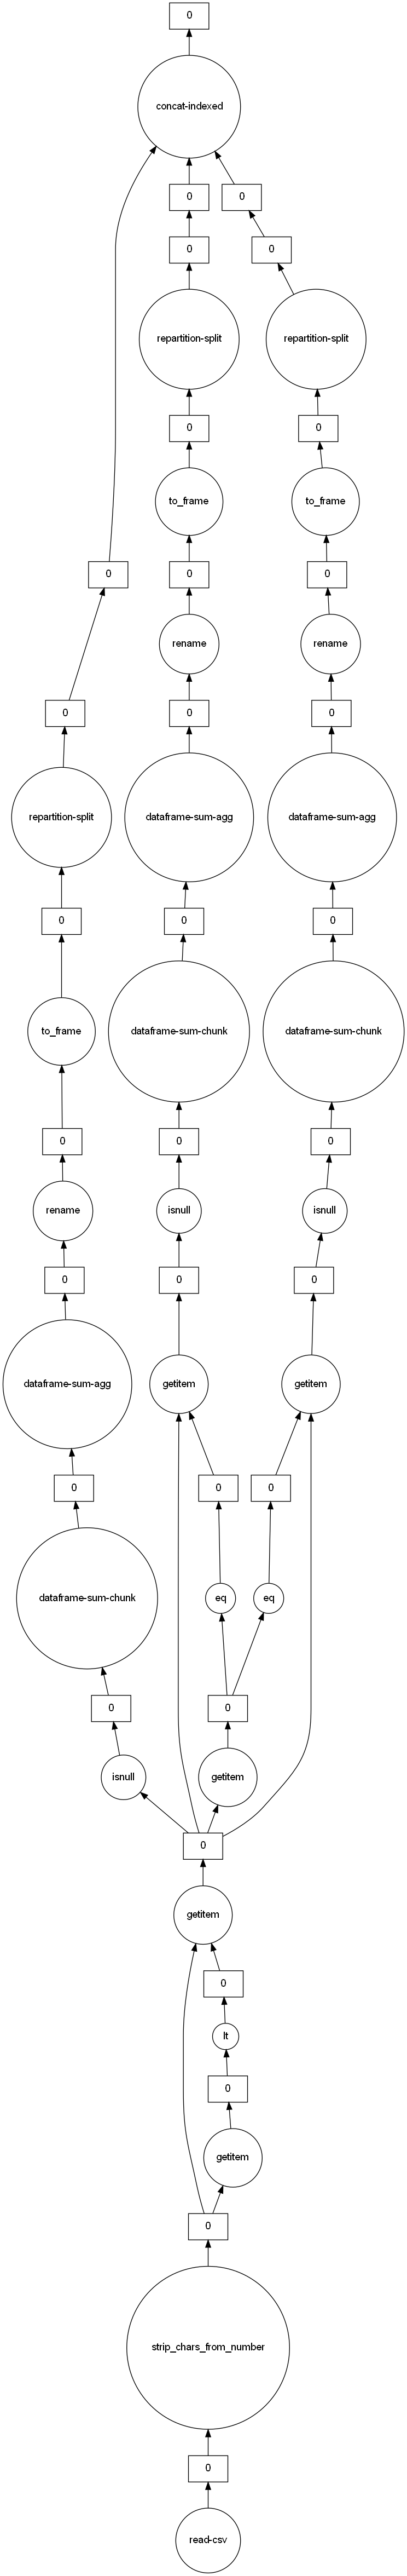

In [11]:
nans_all = df.isnull().sum().rename('n_nulls').to_frame()
nansDefault = df[df.Default == '1'].isnull().sum().rename('n_nulls_dflt').to_frame()
nansNoDefault = df[df.Default == '0'].isnull().sum().rename('n_nulls_no_dflt').to_frame()
nulls = dd.concat([nans_all, nansDefault, nansNoDefault], axis=1)
nulls.visualize()

In [12]:
nulls['n_rows'] = n_rows
nulls['n_rows_dflt'] = len(df[df.Default == '1'])
nulls['n_rows_no_dflt'] = len(df[df.Default == '0'])
nulls['prop_nulls'] = nulls['n_nulls'] / nulls['n_rows']
nulls['prop_nulls_dflt'] = nulls['n_nulls_dflt'] / nulls['n_rows_dflt']
nulls['prop_nulls_no_dflt'] = nulls['n_nulls_no_dflt'] / nulls['n_rows_no_dflt']
nulls = nulls[['n_nulls', 'prop_nulls', 'prop_nulls_dflt', 'prop_nulls_no_dflt']]
nas = nulls.compute().sort_values(by='prop_nulls', ascending=False)
nas

,n_nulls,prop_nulls,prop_nulls_dflt,prop_nulls_no_dflt
Own_House_Age,74878,0.614479,0.693543,0.655556
Score_Source_1,64336,0.527967,0.601703,0.562745
Social_Circle_Default,59034,0.484457,0.584348,0.513505
Client_Occupation,38461,0.315627,0.283712,0.343170
Score_Source_3,24994,0.205111,0.240703,0.218005
Credit_Bureau,17254,0.141593,0.184758,0.148842
ID_Days,5622,0.046136,0.049262,0.049470
Score_Source_2,5311,0.043584,0.043872,0.046970
Loan_Annuity,4528,0.037159,0.042363,0.039605
Client_Income_Type,3439,0.028222,0.029535,0.030314


## Nulls Own_House_Age
There are 80K (65%) Nulls in the Own_House_Age variable. First, I would like to determine if the large quantity of null values is a function of the customer not owning their own home.  The data has binary indicators for homeowner. I counted null values for members who do not own their own homes to determine if the nulls are systematic. We can see that after removing the nulls associated with non-homeowners, there are still 56, 358 null values remaining.

In [13]:
nas.loc[['Own_House_Age'], :]

,n_nulls,prop_nulls,prop_nulls_dflt,prop_nulls_no_dflt
Own_House_Age,74878,0.614479,0.693543,0.655556


Finally, I want to ensure that I am not removing any signal that may point to variation across classes for the customers with populated Own_House_Age. I will look at the distribution to see if data indicates variation or separation between the classes. From reviewing the below visualizations, we can see that there appears to be a systematic data collection issue at 64 months, which affects another ~1,000 customers. While there is a slight variation between the distributions, given a large number of null values and the systematic data collection issues, I will drop this data point.

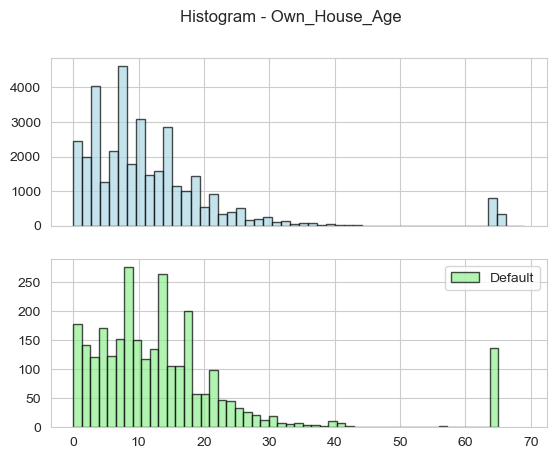

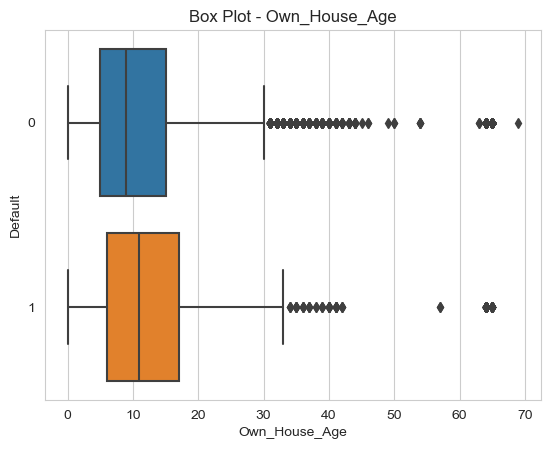

In [14]:
def plot_outcome_dist(data, column):
    """ Plot stacked histograms by outcome for specified column """
    fig, ax = plt.subplots(2, 1, sharex=True)
    fig.suptitle('Histogram - ' + column)
    ax[0].hist(
        data.loc[data.Default == '0', column].compute(),
        edgecolor='black',
        color='lightblue',
        alpha=.7,
        bins=50,
        label='NoDefault'
    )
    ax[1].hist(
        data.loc[data.Default == '1', column].compute(),
        edgecolor='black',
        color='lightgreen',
        alpha=.7,
        bins=50,
        label='Default'
    )
    plt.legend()
    plt.show()

    sns.boxplot(data[[column, 'Default']].compute(), y='Default', x=column) \
        .set_title('Box Plot - ' + column)
    plt.show()

plot_outcome_dist(df[['Own_House_Age', 'Default']], 'Own_House_Age')

## Score Source
Score_Source_1 has 56% null values. Additional Score_Source_3 has 22% null values. Intuitively, I would suspect that a member's credit score would have a strong relationship with defaulted loans. I will visualize all 3 scores side by side to understand the distributions and decide if Score_Source_1 or Score_Source_3 can be dropped without losing valuable information.

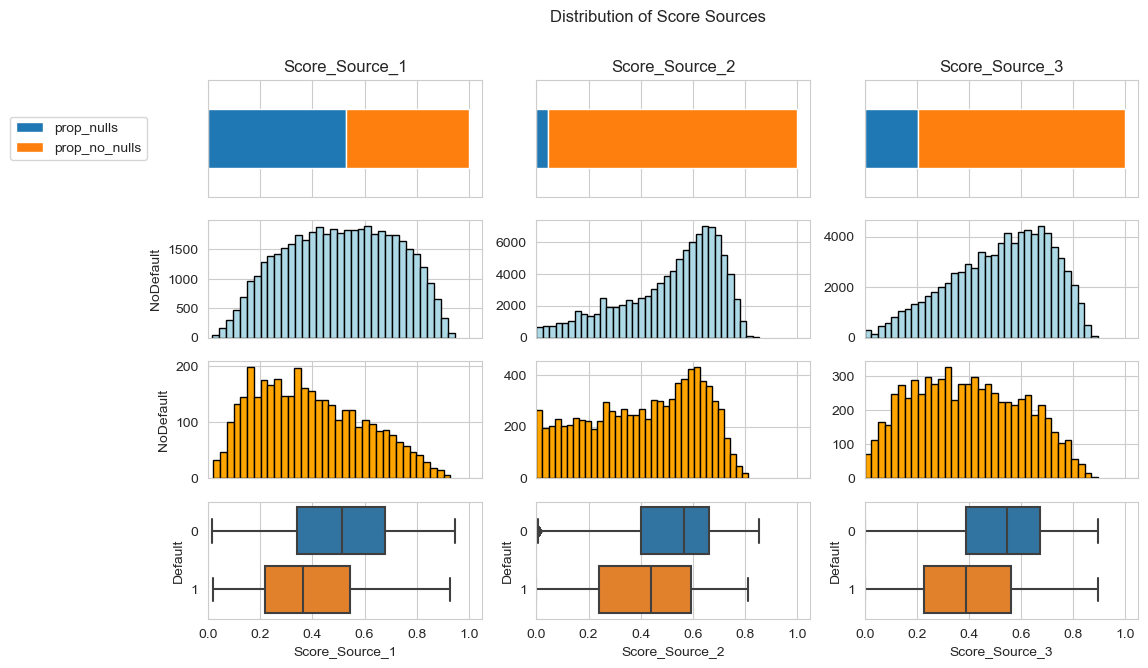

In [15]:
def plot_null_proportion(na_df, column, ax):
    """plot the proportion of nulls as horizontal"""
    plt_nulls_df = na_df.loc[column, :].to_frame().T[['prop_nulls']]
    plt_nulls_df['prop_no_nulls'] = 1 - plt_nulls_df['prop_nulls']
    plt_nulls_df.plot(kind='barh', stacked='True', ax=ax, legend=False)


col_dict = {
    0: (df, 'Score_Source_1'),
    1: (df[df.Score_Source_2 <= 1], 'Score_Source_2'),
    2: (df, 'Score_Source_3')
}

fig, ax = plt.subplots(4, 3, figsize=(12, 7), sharex=True)
fig.suptitle('Distribution of Score Sources')
for j, df_tup in col_dict.items():
    data, col = df_tup
    plot_null_proportion(nas, col, ax[0, j])
    ax[0, j].set_title(col)
    ax[0, j].set_ylabel('proportion nulls')
    ax[0, j].yaxis.set_visible(False)
    if j == 0:
        ax[0, j].legend(loc='center left', bbox_to_anchor=(-.75, 0.5), prop={'size': 10})

    ax[1 ,j].hist(
        data.loc[df.Default == '0', col].compute(),
        edgecolor='black',
        color='lightblue',
        bins=35,
        label='NoDefault'
    )
    ax[2 ,j].hist(
        data.loc[df.Default == '1', col].compute(),
        edgecolor='black',
        color='orange',
        bins=35,
        label='Default'
    )
    sns.boxplot(data[['Default', col]].compute(), y='Default', x=col, ax=ax[3, j])
    if j == 0:
        ax[1, j].set_ylabel('NoDefault')
        ax[2, j].set_ylabel('NoDefault')

plt.show()

In [16]:
df.groupby(['Default']).agg(
    {
        'Score_Source_1':['mean', 'std'],
        'Score_Source_2':['mean', 'std'],
        'Score_Source_3':['mean', 'std']
    }
).compute()

Score_Source_1           Score_Source_2           Score_Source_3  \
                  mean       std           mean       std           mean   
Default                                                                    
0             0.507015  0.208683       0.523392  0.729549       0.521558   
1             0.389057  0.206150       0.421409  1.078673       0.395337   

                   
              std  
Default            
0        0.189877  
1        0.206744

#### Dask Array API & Statistical Testing
We have seen how the syntax of a Dask data frame closely resembles that of Pandas. Dasks also have an array API that parallelizes numpy arrays. The API shares several commonly used methods supplied by numpy. I will illustrate the Dask array API by using it to take a random sample of the data in parallel and pass the sample as a numpy array to the Mann-Whitney U test Scipy function, which will determine if the means of the scores for defaulted loans are statistically different. I chose the Mann-Whiteny test over the T-test because of the strong skew of distributions.

In [17]:
from dask.array.random import choice
from scipy.stats import mannwhitneyu

# To dask array
a_array = df.loc[(df.Default == '1') & (df.Score_Source_1.notnull()), 'Score_Source_1'].to_dask_array(lengths=True)
b_array = df.loc[(df.Default == '1') & (df.Score_Source_2.notnull()), 'Score_Source_2'].to_dask_array(lengths=True)
c_array = df.loc[(df.Default == '1') & (df.Score_Source_3.notnull()), 'Score_Source_3'].to_dask_array(lengths=True)
# Sample
a = choice(a_array, 25000).compute()
b = choice(b_array, 25000).compute()
c = choice(c_array, 25000).compute()
# Non-parm tests
source_1_2_mwu = mannwhitneyu(a, b)
source_2_3_mwu = mannwhitneyu(c, b)
# Review tests
print("Mann-Whitney U tests: ")
print("Score_Source_1 to Score_Source_2:", source_1_2_mwu)
print("Score_Source_3 to Score_Source_2:", source_2_3_mwu)

Mann-Whitney U tests: 
Score_Source_1 to Score_Source_2: MannwhitneyuResult(statistic=287528398.0, pvalue=5.182868770686545e-54)
Score_Source_3 to Score_Source_2: MannwhitneyuResult(statistic=296897740.0, pvalue=4.1125531961729935e-22)


#### Observations
We can observe, that while Score_Source_1 is over 50% null values, the distribution of the defaulted scores has the strongest right skew of the 3 reported scores indicating (as one would suspect) that lower values of Score_Source_1 may have a strong relationship with defaulted loans. We can also see a right skew in Score_Source_3 for Defaulted loans. Conversely, Score Source_2’s defaulted loan distribution has a slight left skew.  I further confirmed that the distribution of scores for members with the defaulted loan differs for Score_Source_2 and Score_Source_1 by conducting the Mann-Whitney test.

Conversely, the distribution of Score_Source_2 and Score_Source_3 for members without defaulted loans is right skewed, while the Score_Source_1 is more uniformly distributed.  Likewise, we can observe from the box plots that the average score in all 3 sources is lower for members with defaulted loans. Also,  the standard deviation for Score_Source_1 and Score_Source_3 is narrower. Score_Source_2.
All of the above indicates that there may be valuable information to be retained here. I will keep all three scores and use the values for feature engineering the following points:

* Average Score
* Min Score
* Max Score

* Finally, I will impute the mean for all missing values in each of the columns.


## Client_Occupation
Operations are parallelized. All intermediary steps are disposed of. Only final results are returned. Keep laborers.

In [18]:
# count non-null occupation categories
occupation_n = df[df.Client_Occupation.notnull()].groupby(['Default', 'Client_Occupation']).size().rename('n_level').to_frame().reset_index()
# count non-null occupation outcomes
occupation_not_null = df[df.Client_Occupation.notnull()].groupby(['Default']).size().rename('total').to_frame()
# join levels to total
occupation_rate = occupation_n.merge(occupation_not_null, how='left', on='Default')
# get rate of n members in group to total members in outcome
occupation_rate['rate'] = occupation_rate['n_level'] / occupation_rate['total']
# Pivot rate by default - note: Dask requires column label be categorical type
occupation_rate = occupation_rate.categorize(columns=['Default']) 
occupation_pvt = occupation_rate.pivot_table(index='Client_Occupation', columns='Default', values='rate')
# difference of rates between outcomes
occupation_pvt['diff'] = occupation_pvt['1'] - occupation_pvt['0']
occupation_pvt.compute()

Default,0,1,diff
Client_Occupation,,,
Accountants,0.047625,0.028141,-0.019484
Cleaning,0.021567,0.023025,0.001458
Cooking,0.027123,0.035214,0.008092
Core,0.134754,0.091949,-0.042805
Drivers,0.086501,0.114221,0.027720
HR,0.002523,0.001655,-0.000867
High skill tech,0.054668,0.034312,-0.020357
IT,0.002377,0.002408,0.000031
Laborers,0.260116,0.310309,0.050192


## Social_Circle_Default
Drop

,n_nulls,prop_nulls,prop_nulls_dflt,prop_nulls_no_dflt
Social_Circle_Default,59034,0.484457,0.584348,0.513505


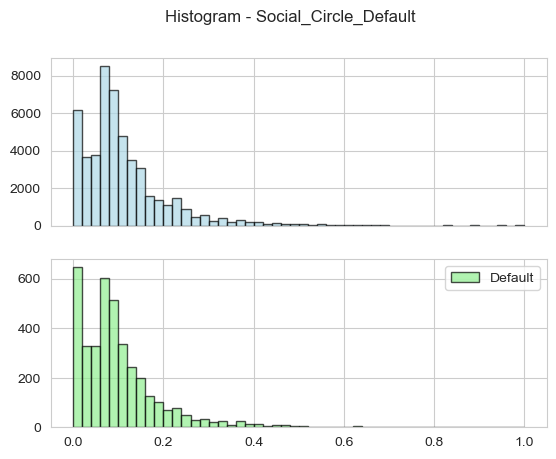

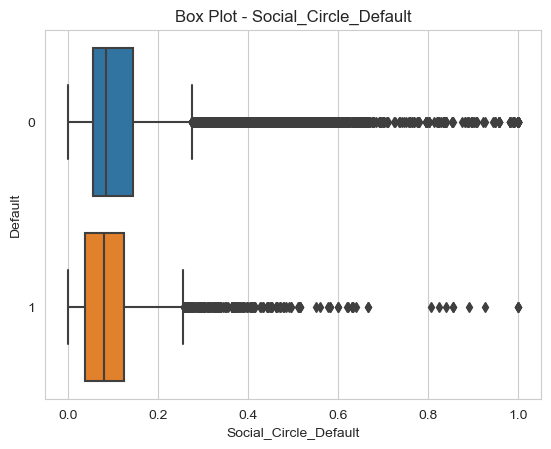

Social_Circle_Default          
                         mean       std
Default                                
0                    0.113484  0.104110
1                    0.101807  0.098952

In [19]:
display(nas.loc[['Social_Circle_Default'],  :])
plot_outcome_dist(df[['Social_Circle_Default', 'Default']], 'Social_Circle_Default')
df.groupby(['Default']).agg({'Social_Circle_Default':['mean', 'std']}).compute()

# Credit_Bureau
Drop

,n_nulls,prop_nulls,prop_nulls_dflt,prop_nulls_no_dflt
Credit_Bureau,17254,0.141593,0.184758,0.148842


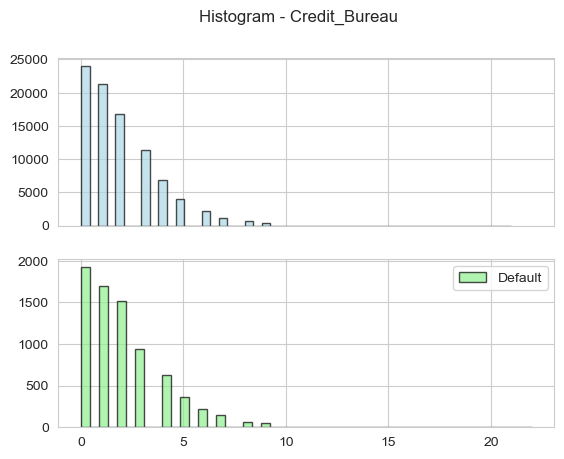

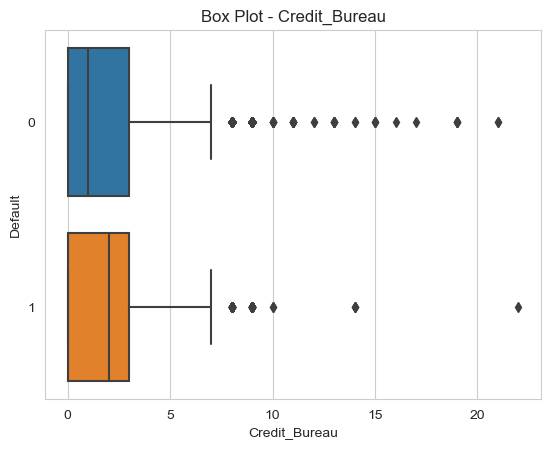

Credit_Bureau          
                 mean       std
Default                        
0            1.883589  1.851606
1            2.024461  1.967485

In [20]:
display(nas.loc[['Credit_Bureau'],  :])
plot_outcome_dist(df[['Credit_Bureau', 'Default']], 'Credit_Bureau')
df.groupby(['Default']).agg({'Credit_Bureau':['mean', 'std']}).compute()

# Erroneous values
• Population_Region_Relative: The metric should be on a 0 -1 scale, but the max value is 100.
• Score_Source_2: Should be on a scale from 0-1. There are values of 100.
• Employed Days: Extreme values

<Axes: xlabel='Employed_Days'>

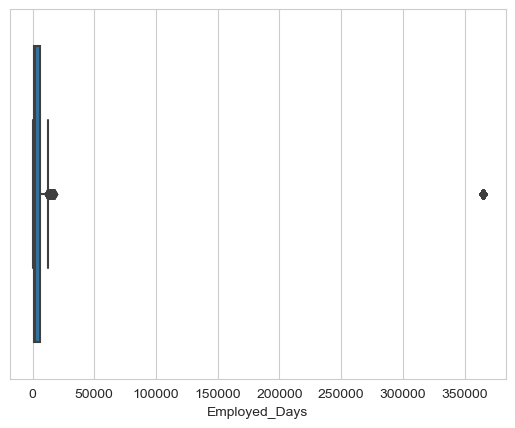

In [21]:
sns.boxplot(df[['Employed_Days']].compute(), x='Employed_Days')

In [22]:
print(len(df[df.Employed_Days > 50000]))
df.loc[df.Employed_Days> 50000, 'Employed_Days'].value_counts().compute()

19669


365243.0    19669
Name: Employed_Days, dtype: int64

In [23]:
df.loc[df.Employed_Days> 50000, 'Default'].value_counts().compute()

0    18575
1     1094
Name: Default, dtype: int64

In [24]:
print('Score_Source_2 value errors: ', len(df[df.Score_Source_2 > 1]))
print('Population_Region_Relative value errors: ', len(df[df.Population_Region_Relative > 1 ] ))
# Drop Erroneous Values
df = df[df.Score_Source_2 <= 1]
df = df[df.Population_Region_Relative <= 1 ]

Score_Source_2 value errors:  6
Population_Region_Relative value errors:  0


## Outliers
### Detect

In [25]:
import dask

def summarize_iqr_outlier(data, col):
    """ Summarizes upper bound outliers based on IQR"""
    outlier_list = [col]
    q1 = data[col].quantile(.25)
    q3 = data[col].quantile(.75)
    iqr = q3 - q1
    threshold = q3 + (iqr * 3)
    outlier_list.extend(dask.compute(iqr, threshold))
    outlier_list.append(len(data[data[col] > threshold]))
    return outlier_list

# df.Child_Count.value_counts().compute().sort_index()
outlier_review_cols = [
    'Client_Income',
    'Child_Count',
    'Credit_Amount',
    'Loan_Annuity',
    'Client_Family_Members',
    'Phone_Change',
    'Age_Days',
    'Employed_Days',
    'Registration_Days',
    'ID_Days',
    'Population_Region_Relative'
]
outlier_review_list = []
for col in outlier_review_cols:
    outlier_review_list.append(summarize_iqr_outlier(df, col))

outlier_df = pd.DataFrame(outlier_review_list, columns=['column', 'iqr', 'threshold', 'n_outliers'])
outlier_df.set_index('column', inplace=True)
outlier_df

,iqr,threshold,n_outliers
column,,,
Client_Income,9000.000000,47250.000000,891
Child_Count,1.000000,4.000000,56
Credit_Amount,53865.000000,242460.000000,121
Loan_Annuity,1786.050000,8789.850000,318
Client_Family_Members,1.000000,6.000000,51
Phone_Change,1298.000000,5464.000000,0
Age_Days,7279.000000,41494.000000,0
Employed_Days,4741.000000,19898.000000,18775
Registration_Days,5438.000000,23733.000000,2


### Remove
Do not remove Employed_Days.

In [26]:
# Extract outlier thresholds
outlier_mask = (outlier_df['n_outliers'] != 0) # (outlier_df.index != 'Employed_Days') &
rm_outliers = outlier_df.loc[outlier_mask, 'threshold'].to_dict()
print('outlier_thresholds: ', rm_outliers)

# Remove outliers
for col, thresh in rm_outliers.items():
    df = df[(df[col] <= thresh) | (df[col].isnull())]

print(f'Length of df removing outliers: {len(df)}')

outlier_thresholds:  {'Client_Income': 47250.0, 'Child_Count': 4.0, 'Credit_Amount': 242460.0, 'Loan_Annuity': 8789.849999999999, 'Client_Family_Members': 6.0, 'Employed_Days': 19898.0, 'Registration_Days': 23733.0}
Length of df removing outliers: 88392


# Feature Engineering - Score

In [27]:
# Scores
scores_cols = [
    'Score_Source_1',
    'Score_Source_2',
    'Score_Source_3'
]

df['scores_mean'] = df[scores_cols].mean(axis=1)
df['scores_min'] = df[scores_cols].min(axis=1)
df['scores_max'] = df[scores_cols].max(axis=1)
df['scores_range'] = df['scores_max'] - df['scores_min']

df[[col for col in df.columns if 'score' in col.lower()]].head()

,Score_Source_1,Score_Source_2,Score_Source_3,scores_mean,scores_min,scores_max,scores_range
0,0.568066,0.478787,NaN,0.523426,0.478787,0.568066,0.089279
1,0.563360,0.215068,NaN,0.389214,0.215068,0.563360,0.348292
2,NaN,0.552795,0.329655,0.441225,0.329655,0.552795,0.223140
4,0.508199,0.301182,0.355639,0.388340,0.301182,0.508199,0.207017
5,NaN,0.697928,0.420611,0.559269,0.420611,0.697928,0.277317


# Drop Columns

In [28]:
# Drop Variables
df = df.drop(columns=['Own_House_Age', 'Client_Occupation', 'Social_Circle_Default', 'Credit_Bureau'])

# Impute Missing Values

In [29]:
from dask.ml.compose import ColumnTransformer
from dask.ml.impute import SimpleImputer

impute_mean_col = [
    'Client_Income',
    'Credit_Amount',
    'Loan_Annuity',
    'Population_Region_Relative',
    'Score_Source_1',
    'Score_Source_2',
    'Score_Source_3',
]
impute_mode_col = [
    'Child_Count',
    'Age_Days',
    'Registration_Days',
    'ID_Days',
    'Employed_Days',
    'Client_Family_Members',
    'Application_Process_Hour',
    'Phone_Change'
]

imputer_frequent = SimpleImputer(strategy='most_frequent')
imputer_mean = SimpleImputer(strategy='mean')
imputer = ColumnTransformer(
    [
        ('most_frequent', imputer_frequent, impute_mode_col),
        ('mean', imputer_mean, impute_mean_col)
    ],
    remainder='passthrough'
)
imputer.fit(df)
imputed = imputer.transform(df)
imputed.head()

,Child_Count,Age_Days,Registration_Days,ID_Days,Employed_Days,Client_Family_Members,Application_Process_Hour,Phone_Change,Client_Income,Credit_Amount,Loan_Annuity,Population_Region_Relative,Score_Source_1,Score_Source_2,Score_Source_3,ID,Car_Owned,Bike_Owned,Active_Loan,House_Own,Accompany_Client,Client_Income_Type,Client_Education,Client_Marital_Status,Client_Gender,Loan_Contract_Type,Client_Housing_Type,Mobile_Tag,Homephone_Tag,Workphone_Working,Cleint_City_Rating,Application_Process_Day,Client_Permanent_Match_Tag,Client_Contact_Work_Tag,Type_Organization,Default,scores_mean,scores_min,scores_max,scores_range
0,0.0,13957.0,6123.0,383.0,1062.0,2.0,17,63.0,6750.0,61190.55,3416.85,0.028663,0.568066,0.478787,0.501086,12142509,0,0,1,0,Alone,Commercial,Secondary,M,Male,CL,Home,1,1,0,2,6,Yes,Yes,Self-employed,0,0.523426,0.478787,0.568066,0.089279
1,0.0,14162.0,7833.0,21.0,4129.0,2.0,10,0.0,20250.0,15282.00,1826.55,0.008575,0.563360,0.215068,0.501086,12138936,1,0,1,NaN,Alone,Service,Graduation,M,Male,CL,Home,1,0,1,2,3,Yes,Yes,Government,0,0.389214,0.215068,0.563360,0.348292
2,1.0,16790.0,6.0,331.0,5102.0,2.0,11,277.0,18000.0,59527.35,2788.20,0.022800,0.476970,0.552795,0.329655,12181264,0,0,1,0,Alone,Service,Graduation dropout,W,Male,CL,Family,1,0,0,2,4,Yes,Yes,Self-employed,0,0.441225,0.329655,0.552795,0.223140
4,2.0,11366.0,5516.0,4043.0,2977.0,4.0,11,674.0,33750.0,133988.40,3547.35,0.020713,0.508199,0.301182,0.355639,12133385,1,0,1,0,Alone,Commercial,Secondary,M,Female,CL,Home,1,0,0,1,3,Yes,Yes,Business Entity Type 3,0,0.388340,0.301182,0.508199,0.207017
5,1.0,13881.0,3910.0,3910.0,1184.0,2.0,10,739.0,11250.0,13752.00,653.85,0.019101,0.476970,0.697928,0.420611,12191614,0,1,1,1,Alone,Service,Secondary,W,Female,CL,Home,1,0,0,2,2,Yes,Yes,Other,0,0.559269,0.420611,0.697928,0.277317


# Drop NA rows
Half the nulls assocated with `Active Loans.` Since Active Loans will be the only loans we will make, I will remove them.

In [30]:
imputed['nas'] = imputed.isna().sum(axis=1)
cleaned = imputed[(imputed.nas == 0 )]
print(len(cleaned))
cleaned.isna().sum().compute()

60651


Child_Count                   0
Age_Days                      0
Registration_Days             0
ID_Days                       0
Employed_Days                 0
Client_Family_Members         0
Application_Process_Hour      0
Phone_Change                  0
Client_Income                 0
Credit_Amount                 0
Loan_Annuity                  0
Population_Region_Relative    0
Score_Source_1                0
Score_Source_2                0
Score_Source_3                0
ID                            0
Car_Owned                     0
Bike_Owned                    0
Active_Loan                   0
House_Own                     0
Accompany_Client              0
Client_Income_Type            0
Client_Education              0
Client_Marital_Status         0
Client_Gender                 0
Loan_Contract_Type            0
Client_Housing_Type           0
Mobile_Tag                    0
Homephone_Tag                 0
Workphone_Working             0
Cleint_City_Rating            0
Applicat

## Check Class Balance
Class balances remains the same after cleaning.

In [31]:
cleaned.Default.value_counts().compute() / len(cleaned)

0    0.912813
1    0.087187
Name: Default, dtype: float64

# Correlation

C:\Users\Steven Glover\anaconda3\envs\dask-env\lib\site-packages\dask\dataframe\core.py:7270: FutureWarning: The default value of numeric_only will be `False` in a future version of Dask.
  warnings.warn(


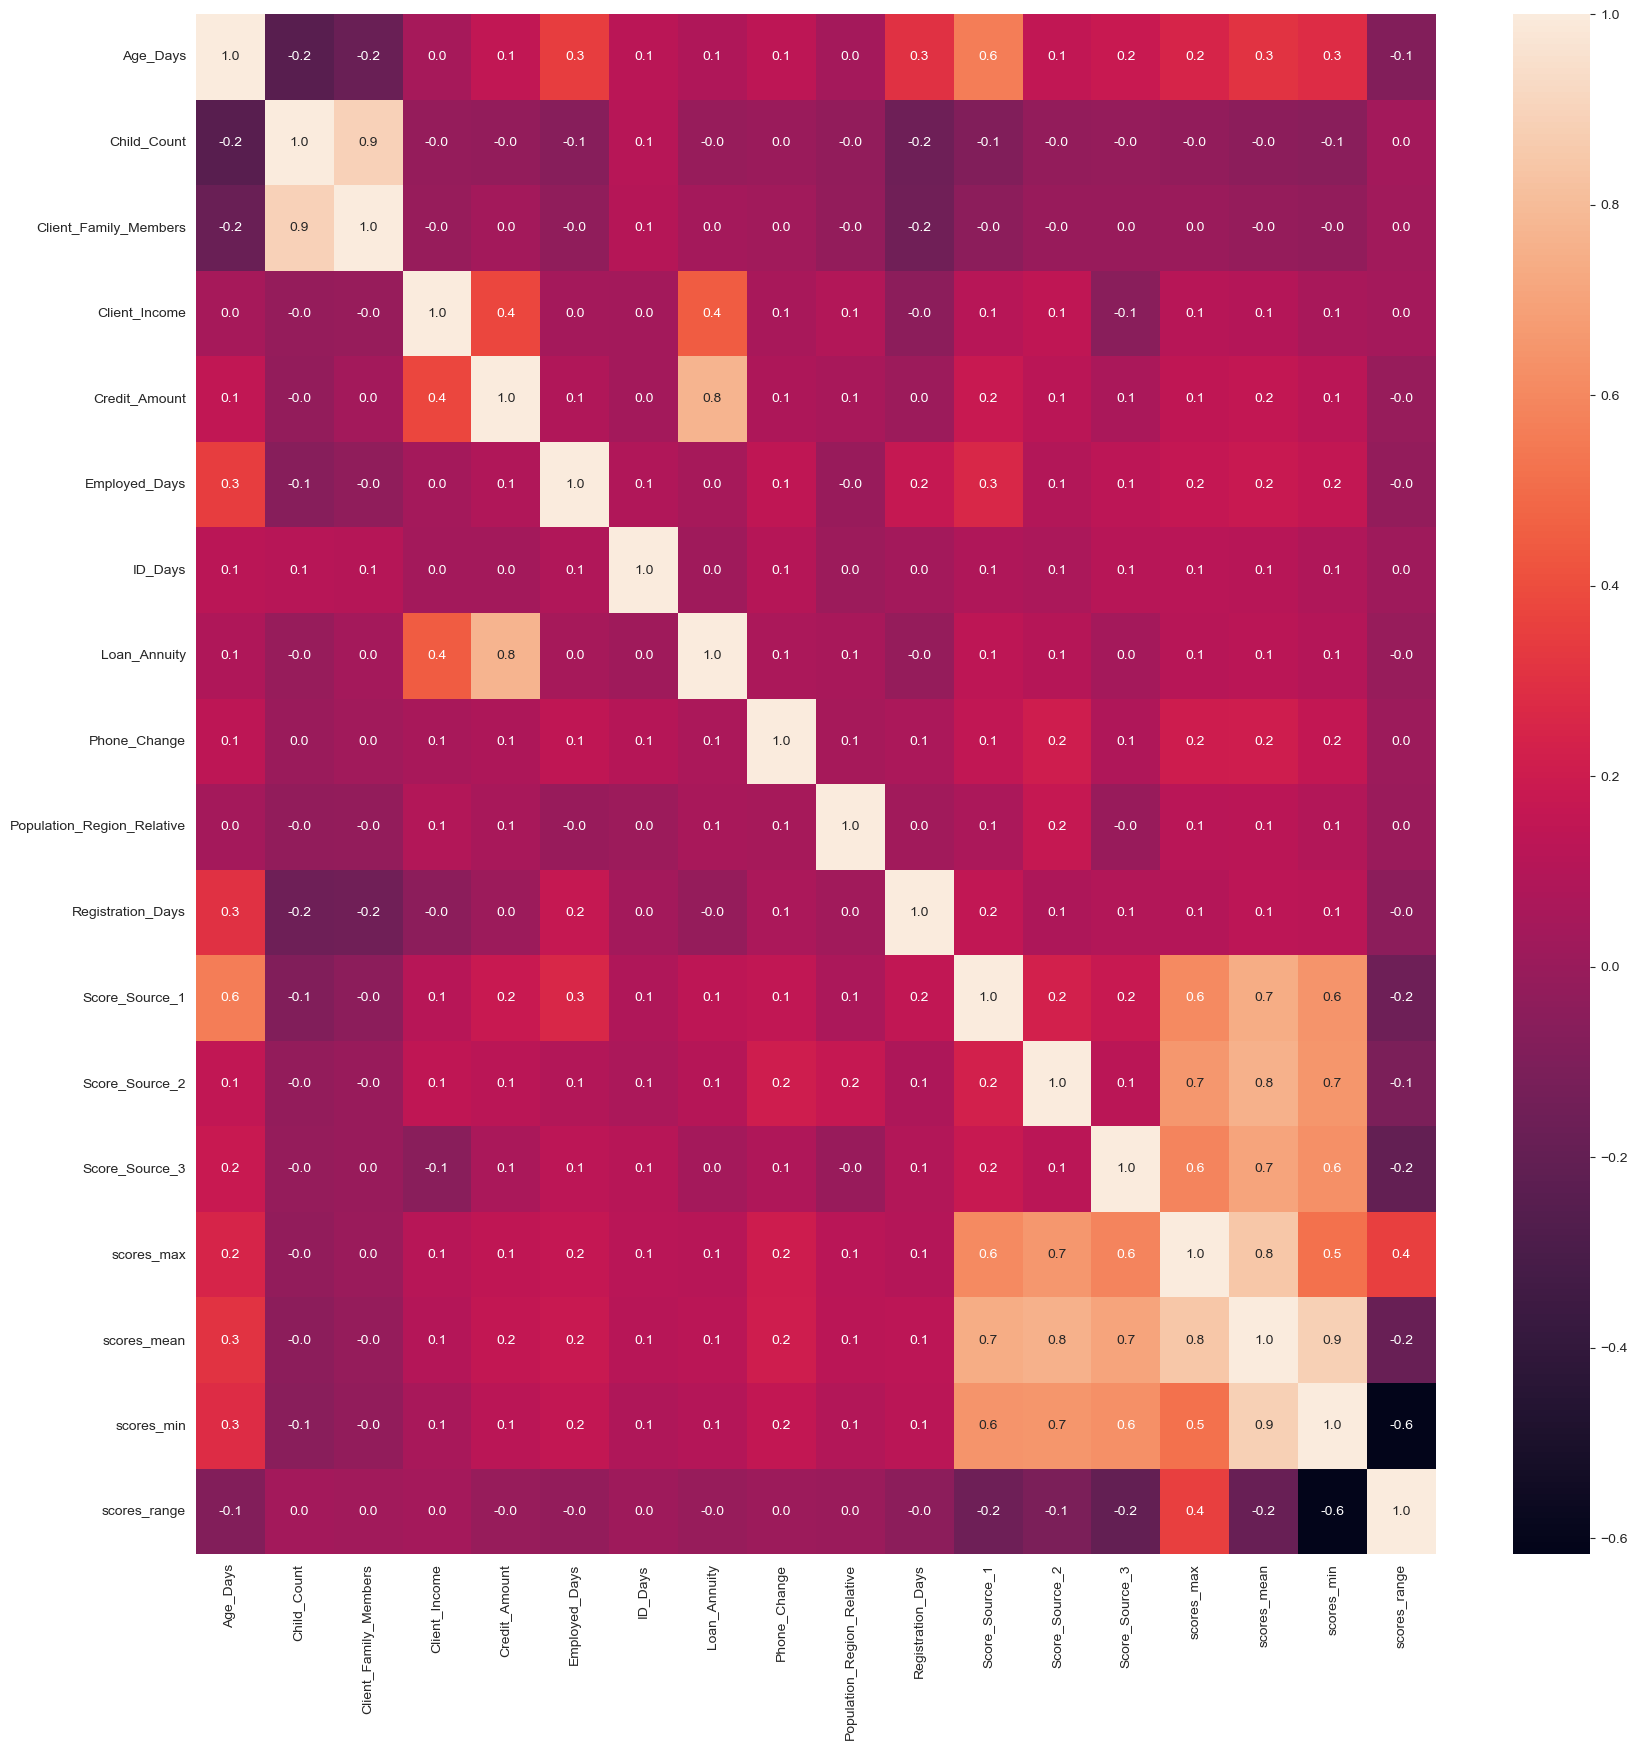

In [32]:
corr_cols = sorted(list(set([col for col in df.columns if 'score' in col.lower()] \
                     + [col for col in df.columns if "Days" in col or "Months" in col or "Years" in col] \
                     + impute_mean_col \
                    + impute_mode_col)))

plt.figure(figsize=(20, 20))
correlations = df[corr_cols].corr().compute()
sns.heatmap(correlations, annot=True, fmt=".1f")
plt.show()

# Do Split before Transforming - That way we can map back clusters to actual values
Since we have an imbalanced problem we need tDask does not support stratified train test split.

https://docs.dask.org/en/stable/generated/dask.dataframe.DataFrame.sample.html

In [33]:
import dask.dataframe as dd

# Treat application process day/hour as numeric
cleaned['Application_Process_Day'] = cleaned['Application_Process_Day'].astype(float)
cleaned['Application_Process_Hour'] = cleaned['Application_Process_Hour'].astype(float)
cleaned['Default'] = cleaned['Default'].astype(int)

# Subset neg pos class
neg_class = cleaned[cleaned.Default == 0].copy()
pos_class = cleaned[cleaned.Default == 1].copy()

# Sample 80% for train and take the remainder for test
neg_class_train = neg_class.sample(frac=.8, replace=False, random_state=0)
neg_class_validate = neg_class[~neg_class.ID.isin(neg_class_train.ID.unique().compute())].copy()
pos_class_train = pos_class.sample(frac=.8, replace=False, random_state=0)
pos_class_validate = pos_class[~pos_class.ID.isin(pos_class_train.ID.unique().compute())].copy()

# Drop ID from datasets
neg_class_train = neg_class_train.drop(columns=['ID'])
pos_class_train = pos_class_train.drop(columns=['ID'])
neg_class_validate = neg_class_validate.drop(columns=['ID'])
pos_class_validate = pos_class_validate.drop(columns=['ID'])

# Concatenate Positive and Negative Class
train_subset = dd.concat([neg_class_train, pos_class_train])
validate_subset = dd.concat([neg_class_validate, pos_class_validate])

# Neg Class Sample Validation
neg_class_rows = len(neg_class)
neg_class_train_rows = len(neg_class_train)
neg_class_validate_rows = len(neg_class_validate)
pos_class_rows = len(pos_class)
pos_class_train_rows = len(pos_class_train)
pos_class_validate_rows = len(pos_class_validate)

print('Negative Class Sample Validation')
print('---------------------------------------------------------')
print('neg class rows: ' , neg_class_rows)
print('neg class train: ', neg_class_train_rows)
print('neg class test: ', neg_class_validate_rows)
print('Test neg_class data (diff): ', neg_class_rows - neg_class_train_rows - neg_class_validate_rows)
print('\n')
print('Positive Class Sample Validation')
print('---------------------------------------------------------')
print('pos class rows: ' , pos_class_rows)
print('pos class train: ', pos_class_train_rows)
print('pos class test: ', pos_class_validate_rows)
print('Test neg_class data (diff): ', pos_class_rows - pos_class_train_rows - pos_class_validate_rows)
print('\n')
print("Train / Test Rows Validation")
print('---------------------------------------------------------')
print('train validation: ', len(train_subset) - pos_class_train_rows - neg_class_train_rows)
print('test set validation: ', len(validate_subset) - pos_class_validate_rows - neg_class_validate_rows)
print('train balance: ')
display(train_subset.Default.value_counts().compute()/ len(train_subset))
print('train balance: ')
display(validate_subset.Default.value_counts().compute() / len(validate_subset))

Negative Class Sample Validation
---------------------------------------------------------
neg class rows:  55363
neg class train:  44290
neg class test:  11073
Test neg_class data (diff):  0


Positive Class Sample Validation
---------------------------------------------------------
pos class rows:  5288
pos class train:  4230
pos class test:  1058
Test neg_class data (diff):  0


Train / Test Rows Validation
---------------------------------------------------------
train validation:  0
test set validation:  0
train balance: 


0    0.912819
1    0.087181
Name: Default, dtype: float64

train balance: 


0    0.912785
1    0.087215
Name: Default, dtype: float64

# Transform

In [34]:
from sklearn.pipeline import Pipeline
from dask_ml.preprocessing import MinMaxScaler
from dask_ml.preprocessing import StandardScaler
from dask.ml.preprocessing import OneHotEncoder
from dask_ml.preprocessing import Categorizer, DummyEncoder

scale_cols = [
    'Client_Income',
    'Child_Count',
    'Credit_Amount',
    'Loan_Annuity',
    'Population_Region_Relative',
    'Age_Days',
    'Employed_Days',
    'Registration_Days',
    'ID_Days',
    'Client_Family_Members',
    'Application_Process_Day',
    'Application_Process_Hour',
    'Score_Source_1',
    'Score_Source_2',
    'Score_Source_3',
    'Phone_Change',
    'scores_mean',
    'scores_min',
    'scores_max',
    'scores_range'
]
ohe_cols = [
    'Car_Owned',
    'Bike_Owned',
    'Active_Loan',
    'House_Own',
    'Accompany_Client',
    'Client_Income_Type',
    'Client_Marital_Status',
    'Client_Gender',
    'Loan_Contract_Type',
    'Client_Housing_Type',
    'Mobile_Tag',
    'Homephone_Tag',
    'Workphone_Working',
    'Client_Permanent_Match_Tag',
    'Client_Contact_Work_Tag',
    'Type_Organization',
    'Client_Education',
    'Cleint_City_Rating'
]
ohe = OneHotEncoder(sparse=False)
ohe_pipeline = Pipeline([('categorizer', Categorizer()), ('ohe', DummyEncoder())])
preprocessing = ColumnTransformer(
    [
        ('scaler', StandardScaler(), scale_cols),
        ('ohe', ohe_pipeline, ohe_cols)
    ],
    remainder='passthrough'
)
preprocessing.fit(train_subset)
train = preprocessing.transform(train_subset)
validate = preprocessing.transform(validate_subset)
train.head()

,Client_Income,Child_Count,Credit_Amount,Loan_Annuity,Population_Region_Relative,Age_Days,Employed_Days,Registration_Days,ID_Days,Client_Family_Members,Application_Process_Day,Application_Process_Hour,Score_Source_1,Score_Source_2,Score_Source_3,Phone_Change,scores_mean,scores_min,scores_max,scores_range,Car_Owned_0,Car_Owned_1,Bike_Owned_0,Bike_Owned_1,Active_Loan_0,Active_Loan_1,House_Own_0,House_Own_1,Accompany_Client_##,Accompany_Client_Alone,Accompany_Client_Group,Accompany_Client_Kids,Accompany_Client_Others,Accompany_Client_Partner,Accompany_Client_Relative,Client_Income_Type_Commercial,Client_Income_Type_Govt Job,Client_Income_Type_Retired,Client_Income_Type_Service,Client_Income_Type_Student,Client_Income_Type_Unemployed,Client_Marital_Status_D,Client_Marital_Status_M,Client_Marital_Status_S,Client_Marital_Status_W,Client_Gender_Female,Client_Gender_Male,Client_Gender_XNA,Loan_Contract_Type_CL,Loan_Contract_Type_RL,Client_Housing_Type_Family,Client_Housing_Type_Home,Client_Housing_Type_Municipal,Client_Housing_Type_Office,Client_Housing_Type_Rental,Client_Housing_Type_Shared,Mobile_Tag_1,Homephone_Tag_0,Homephone_Tag_1,Workphone_Working_0,Workphone_Working_1,Client_Permanent_Match_Tag_No,Client_Permanent_Match_Tag_Yes,Client_Contact_Work_Tag_No,Client_Contact_Work_Tag_Yes,Type_Organization_Advertising,Type_Organization_Agriculture,Type_Organization_Bank,Type_Organization_Business Entity Type 1,Type_Organization_Business Entity Type 2,Type_Organization_Business Entity Type 3,Type_Organization_Cleaning,Type_Organization_Construction,Type_Organization_Culture,Type_Organization_Electricity,Type_Organization_Emergency,Type_Organization_Government,Type_Organization_Hotel,Type_Organization_Housing,Type_Organization_Industry: type 1,Type_Organization_Industry: type 10,Type_Organization_Industry: type 11,Type_Organization_Industry: type 12,Type_Organization_Industry: type 13,Type_Organization_Industry: type 2,Type_Organization_Industry: type 3,Type_Organization_Industry: type 4,Type_Organization_Industry: type 5,Type_Organization_Industry: type 6,Type_Organization_Industry: type 7,Type_Organization_Industry: type 8,Type_Organization_Industry: type 9,Type_Organization_Insurance,Type_Organization_Kindergarten,Type_Organization_Legal Services,Type_Organization_Medicine,Type_Organization_Military,Type_Organization_Mobile,Type_Organization_Other,Type_Organization_Police,Type_Organization_Postal,Type_Organization_Realtor,Type_Organization_Religion,Type_Organization_Restaurant,Type_Organization_School,Type_Organization_Security,Type_Organization_Security Ministries,Type_Organization_Self-employed,Type_Organization_Services,Type_Organization_Telecom,Type_Organization_Trade: type 1,Type_Organization_Trade: type 2,Type_Organization_Trade: type 3,Type_Organization_Trade: type 4,Type_Organization_Trade: type 5,Type_Organization_Trade: type 6,Type_Organization_Trade: type 7,Type_Organization_Transport: type 1,Type_Organization_Transport: type 2,Type_Organization_Transport: type 3,Type_Organization_Transport: type 4,Type_Organization_University,Type_Organization_XNA,Client_Education_Graduation,Client_Education_Graduation dropout,Client_Education_Junior secondary,Client_Education_Post Grad,Client_Education_Secondary,Cleint_City_Rating_1,Cleint_City_Rating_2,Cleint_City_Rating_3,Default,nas
43966,-0.661425,-0.640802,0.029892,-0.700604,-0.977378,1.089221,-0.900320,0.912564,-0.388412,-0.262238,1.040101,-0.335894,-0.001549,1.034697,1.466787,-0.373959,1.547593,1.711786,0.944797,-0.999526,0,1,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
2614,1.381169,-0.640802,0.912883,0.043617,-1.095046,0.879871,-0.121314,-0.426275,-0.889771,-0.262238,0.476201,-0.335894,1.428444,0.807828,0.675957,0.531510,1.033024,1.227195,0.468689,-0.907770,0,1,1,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,

In [35]:
X_train = train.drop(columns=['Default'])
y_train = train[['Default']]
X_validate = validate.drop(columns=['Default'])
y_validate = validate[['Default']]

# Check point
***
## Write to Parquet

In [36]:
X_train.to_parquet('data/X_train', engine="pyarrow")
y_train.to_parquet('data/y_train', engine="pyarrow")
X_validate.to_parquet('data/X_validate', engine="pyarrow")
y_validate.to_parquet('data/y_validate', engine="pyarrow")
train_subset.to_parquet('data/train_subset', engine="pyarrow")
validate_subset.to_parquet('data/validate_subset', engine="pyarrow")

## Read Parquet

In [4]:
X_train = dd.read_parquet('data/X_train', engine="pyarrow")
y_train = dd.read_parquet('data/y_train', engine="pyarrow")
X_validate = dd.read_parquet('data/X_validate', engine="pyarrow")
y_validate = dd.read_parquet('data/y_validate', engine="pyarrow")
train_subset = dd.read_parquet('data/train_subset', engine="pyarrow")
validate_subset = dd.read_parquet('data/validate_subset', engine="pyarrow")

# Feature Importance

<Axes: >

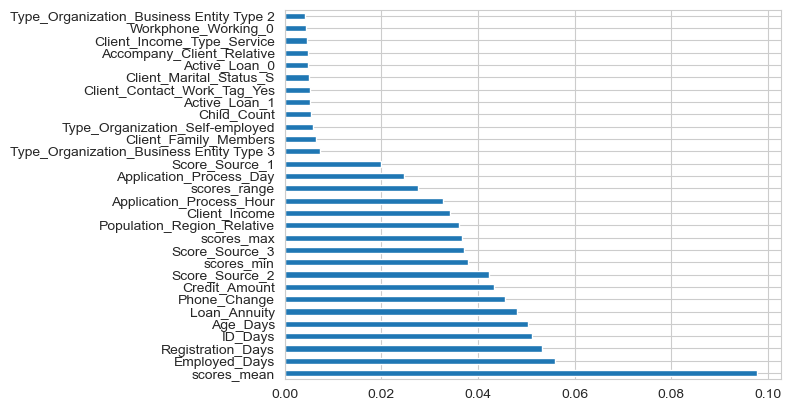

In [5]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(X_train.values.compute(), y_train.values.compute().ravel())
feature_importance = pd.Series(dt.feature_importances_, index=X_train.columns)
feature_importance.sort_values(ascending=False)[:30].sort_values(ascending=False).plot(kind='barh')

## Remove correlated variables
* **Client_Family_Members**	and Child Count: 0.9
* **Credit Amount**	Loan Annuity	0.8
* Scores - All Scores Highly Corrleated, Take Mean as it has the most meaningful relationship


In [6]:
# Drop highly correlated columns
rm_corr_cols = ['Child_Count', 'Loan_Annuity', 'Score_Source_1', 'Score_Source_2',
                'Score_Source_3', 'scores_min', 'scores_max', 'scores_range']

X_train = X_train.drop(columns=rm_corr_cols)
X_validate = X_validate.drop(columns=rm_corr_cols)

# Extract numeric cols for clustering
dtypes = X_train.dtypes
numeric_cols = dtypes[dtypes== 'float64'].index.tolist()
numeric_cols

['Client_Income',
 'Credit_Amount',
 'Population_Region_Relative',
 'Age_Days',
 'Employed_Days',
 'Registration_Days',
 'ID_Days',
 'Client_Family_Members',
 'Application_Process_Day',
 'Application_Process_Hour',
 'Phone_Change',
 'scores_mean']

In [7]:
numeric_cols.remove('Application_Process_Day')
numeric_cols.remove('Application_Process_Hour')

# Clustering
## Choosing K
Discuss issues with kmeans implementation.

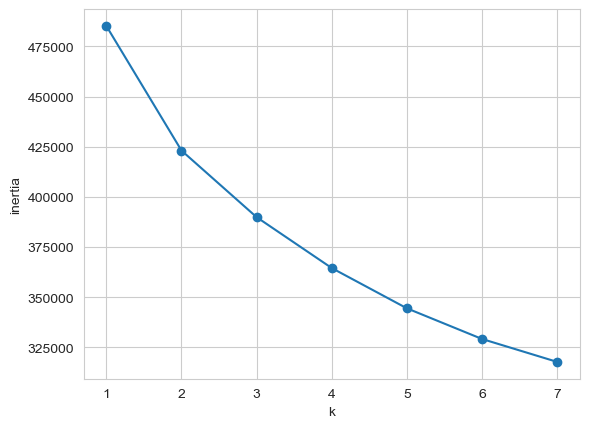

In [8]:
#from dask_ml.cluster import KMeans
from sklearn.cluster import KMeans
import joblib
# dask.config.set(scheduler='threads') # Try this if it fails again.

ks = range(1, 8)
inertias = []
for k in ks:
    # with joblib.parallel_backend('dask'):
    model = KMeans(n_clusters=k)
    model.fit(X_train[numeric_cols].compute())
    inertias.append(model.inertia_)

plt.plot(ks, inertias, '-o')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

### Cluster

In [9]:
km = KMeans(n_clusters=3)
km.fit(X_train[numeric_cols].compute())

KMeans(n_clusters=3)

### PCA to Visualize Clusters

In [10]:
from dask_ml.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X_train[numeric_cols].to_dask_array(lengths=True))
pcs = pca.transform(X_train[numeric_cols].to_dask_array(lengths=True))

### Clusters and Default

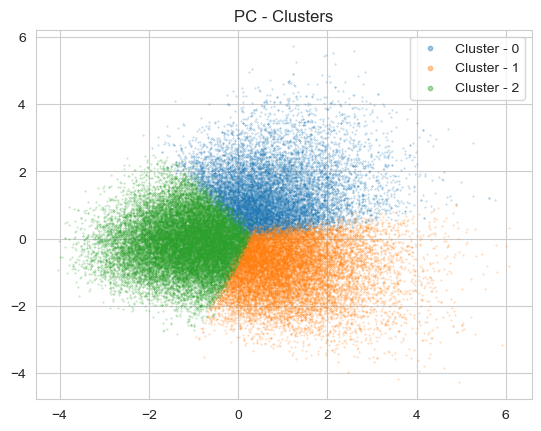

In [11]:
pcs_df = dd.from_dask_array(pcs, columns=['pc1', 'pc2']).compute()
pcs_df['clusters'] = km.labels_
pcs_df['default'] = y_train['Default'].values.compute()

# pcs = pcs.compute()
fig, ax = plt.subplots()
# fig.title("PCA - Cluster")
for cluster in sorted(pcs_df.clusters.unique()):
    mask = (pcs_df.clusters == cluster)
    ax.scatter(
        pcs_df.loc[mask, 'pc1'],
        pcs_df.loc[mask, 'pc2'],
        label='Cluster - ' + str(cluster),
        marker='.',
        alpha=.4,
        s=.5
    )
ax.set_title('PC - Clusters')
lgnd = plt.legend(loc="upper right", scatterpoints=1, fontsize=10)
lgnd.legend_handles[0]._sizes = [40]
lgnd.legend_handles[1]._sizes = [40]
lgnd.legend_handles[2]._sizes = [40]
plt.show()

In [12]:
cluster_default = y_train.Default.to_frame().compute()
cluster_default['Cluster'] = km.labels_
cluster_ct = pd.crosstab(cluster_default.Default, cluster_default.Cluster).T
cluster_ct['cluster_total'] = cluster_ct.sum(axis=1)
cluster_ct['prop_default_in_cluster'] = cluster_ct[1] / cluster_ct['cluster_total']
cluster_ct['prop_default_in_all'] = cluster_ct[1] / cluster_ct[1].sum()
cluster_ct

Default,0,1,cluster_total,prop_default_in_cluster,prop_default_in_all
Cluster,,,,,
0,11275,716,11991,0.059711,0.169267
1,14043,803,14846,0.054089,0.189835
2,18972,2711,21683,0.125029,0.640898


### Cluster Profiles

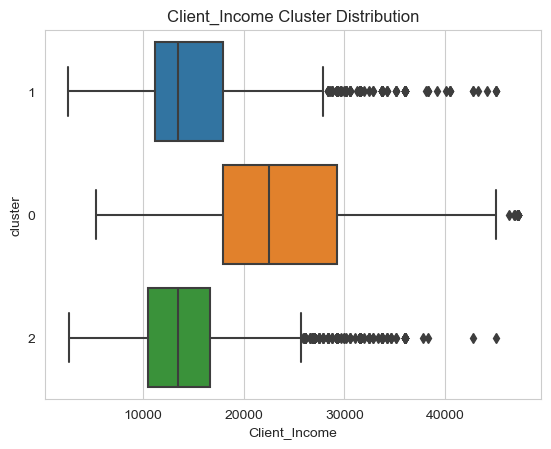

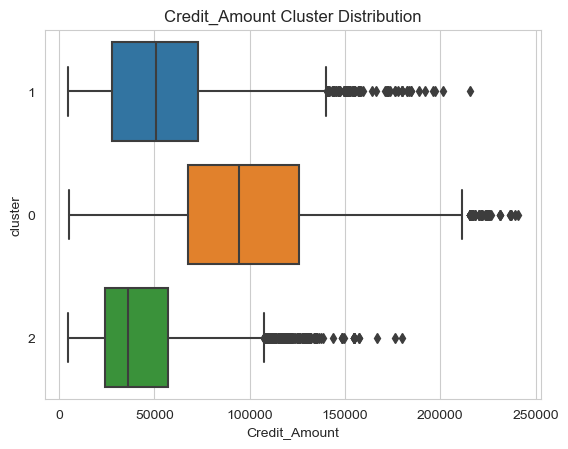

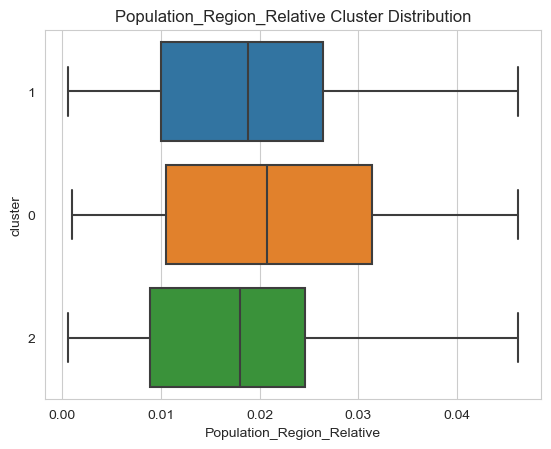

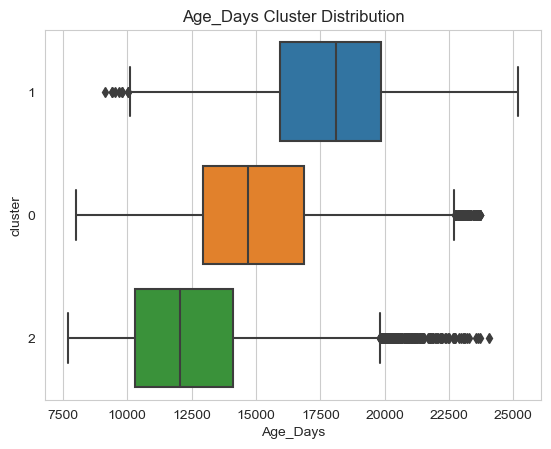

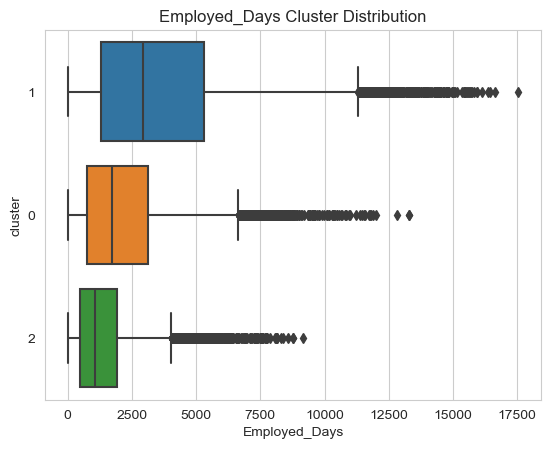

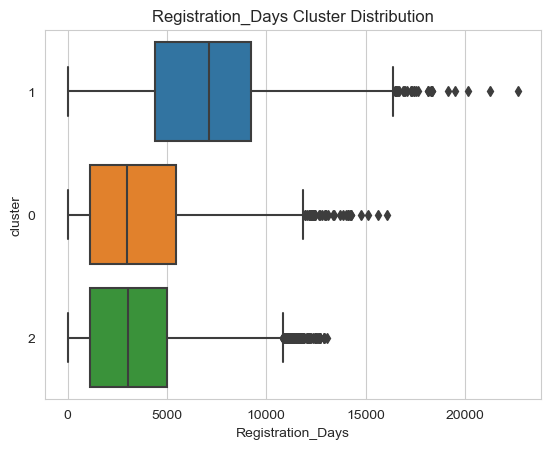

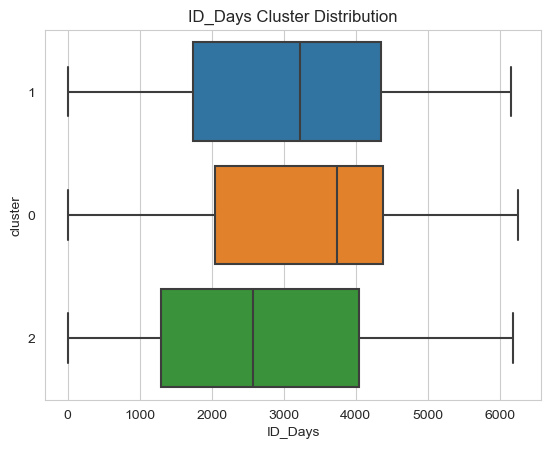

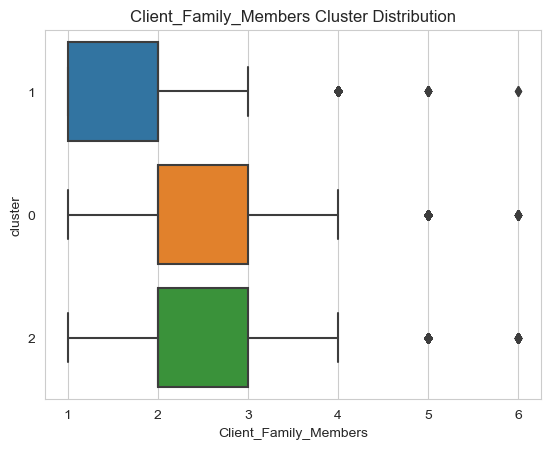

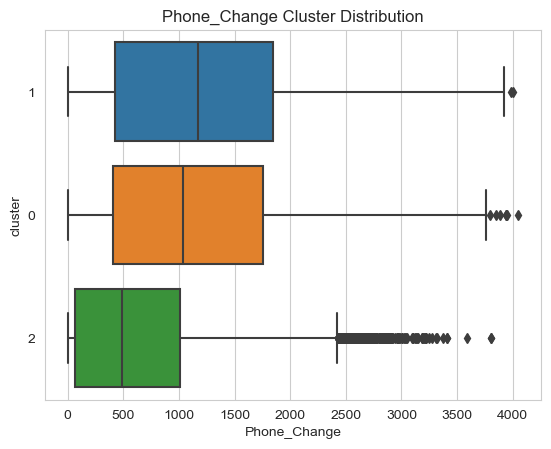

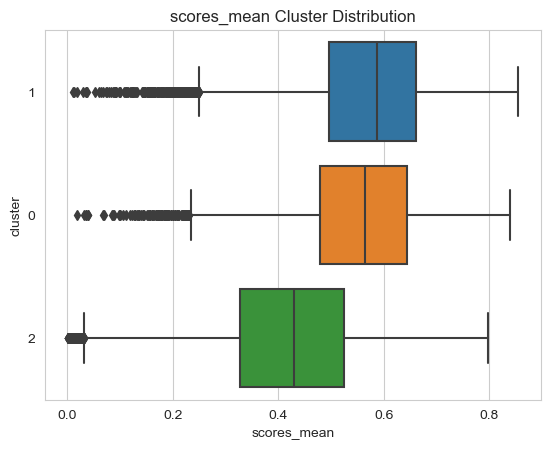

In [14]:
import seaborn as sns

cluster_profiles = train_subset[numeric_cols].compute()
cluster_profiles['cluster'] = km.labels_
cluster_profiles['cluster'] = cluster_profiles['cluster'].astype(str)

for col in numeric_cols:
    fig, ax = plt.subplots()
    sns.boxplot(data=cluster_profiles[[col, 'cluster']], x=col, y='cluster', ax=ax)
    ax.set_title(col + ' Cluster Distribution')
    plt.show()

del cluster_profiles

# Modeling
# Base Model: Random Forest

In [24]:
features = feature_importance[~feature_importance.index.isin(rm_corr_cols)].sort_values(ascending=False)[:11].index.tolist()
features

['scores_mean',
 'Employed_Days',
 'Registration_Days',
 'ID_Days',
 'Age_Days',
 'Phone_Change',
 'Credit_Amount',
 'Population_Region_Relative',
 'Client_Income',
 'Application_Process_Hour',
 'Application_Process_Day']

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
import numpy as np
import joblib

rf = RandomForestClassifier()
with joblib.parallel_backend('dask'):
    rf.fit(X_train[features].values.compute(), y_train.values.compute().ravel())

In [107]:
class ModelLog:
    """ Log classification and metrics and evaluation curves"""
    def __init__(self, model, X, y, label):
        self.model = model
        self.y_pred = model.predict(X)
        self.y_score = model.predict_proba(X)
        self.y_true = y
        self.label = label
        self.metrics = self.get_metrics()

    def get_metrics(self):
        """ compute classification metrics """
        metrics = {
            'accuracy':  accuracy_score(self.y_true, self.y_pred),
            'precision': precision_score(self.y_true, self.y_pred),
            'recall': recall_score(self.y_true, self.y_pred),
            'f1': f1_score(self.y_true, self.y_pred),
            'kappa': cohen_kappa_score(self.y_true, self.y_pred),
            'roc': roc_auc_score(self.y_true, self.y_score[:, 1])
        }
        return pd.DataFrame(metrics, index=[self.label]).T

    def print_classification_report(self):
        """print sklearn classification report"""
        print(classification_report(self.y_true, self.y_pred))

    def print_confusion_matrix(self):
        """ print confusion matrix heat map"""
        matrix_df = pd.DataFrame(confusion_matrix(self.y_true, self.y_pred), index=[0, 1], columns=[0, 1])
        sns.heatmap(matrix_df, annot=True, cmap='Blues', fmt='g')
        plt.show()

    def plot_curves(self):
        """Plot precision and recall curves"""
        ### ROC Curve
        y_true = y_validate.compute()
        # ROC Curve Data
        null_probs = [0 for _ in range(len(preds))]
        null_fpr, null_tpr, _ = roc_curve(self.y_true, null_probs)
        model_fpr, model_tpr, _ = roc_curve(self.y_true, self.y_score[:, 1])
        # Precision - Recall Data
        no_skill = len(self.y_true[self.y_true['Default'] == 1]) / len(self.y_true)
        precision, recall, _ = precision_recall_curve(y_true, proba[:, 1])
        # Plot ROC
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
        ax1.set_title('ROC Curve')
        ax1.plot(null_fpr, null_tpr, linestyle='--', color='grey')
        ax1.plot(model_fpr, model_tpr,  color='lightblue', label=f'ROC AUC {round(roc_auc_score(self.y_true, self.y_score[:, 1]),3)}')
        ax1.set_xlabel('FPR')
        ax1.set_ylabel('TPR')
        ax1.legend()
        # Plot Precision-Recall Curve
        ax2.set_title('Precision- Recall Curve')
        ax2.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
        ax2.plot(recall, precision)
        ax2.set_xlabel('recall')
        ax2.set_ylabel('precision')
        ax2.legend()
        plt.show()

    def assess_prediction_threshold(self):
        """ Evaluate classification metrics at thresholds """
        thresholds = list(np.arange(.05, 1, .05))
        threshold_df = pd.DataFrame()
        # Evaluate scores at each cutoff threshold
        for i, thresh in enumerate(thresholds):
            probs = self.y_score[:, 1]
            y_pred = np.where(probs > thresh, 1, 0)
            cm = confusion_matrix(self.y_true, y_pred)
            row = pd.DataFrame(
                {
                    'threshold': thresh,
                    'TP': cm[1, 1],
                    'TN': cm[0, 0],
                    'FP': cm[0, 1],
                    'FN': cm[1, 0],
                    'Accuracy': accuracy_score(self.y_true, y_pred),
                    'Precision': precision_score(self.y_true, y_pred),
                    'Recall': recall_score(self.y_true, y_pred),
                    'f1': f1_score(self.y_true, y_pred),
                    'Kappa': cohen_kappa_score(self.y_true, y_pred)
                },
                index=[i]
            )
            threshold_df = pd.concat([threshold_df, row], axis=0)
        return threshold_df

    def print_report(self):
        print(self.metrics)
        print('\n')
        self.print_classification_report()
        self.print_confusion_matrix()
        self.plot_curves()

    def __repr__(self):
        return str(self.label)

class ExperimentLog:
    """Log to record experiments"""
    def __init__(self):
        self.model = {}

    def record_experiment(self, model_log):
        """ Log experiment to dictionary """
        self.model[model_log.label] = model_log

           RandomForest-Baseline
accuracy                0.920122
precision               0.949495
recall                  0.088847
f1                      0.162489
kappa                   0.149800
roc                     0.744048


              precision    recall  f1-score   support

           0       0.92      1.00      0.96     11073
           1       0.95      0.09      0.16      1058

    accuracy                           0.92     12131
   macro avg       0.93      0.54      0.56     12131
weighted avg       0.92      0.92      0.89     12131



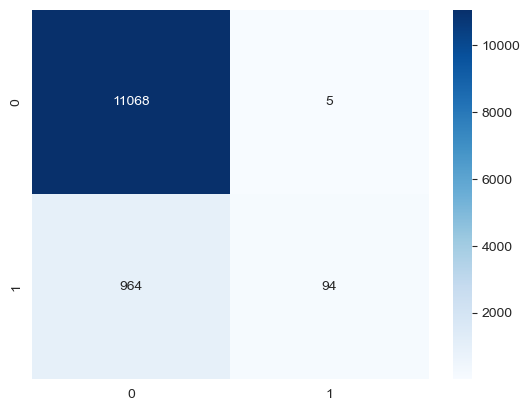

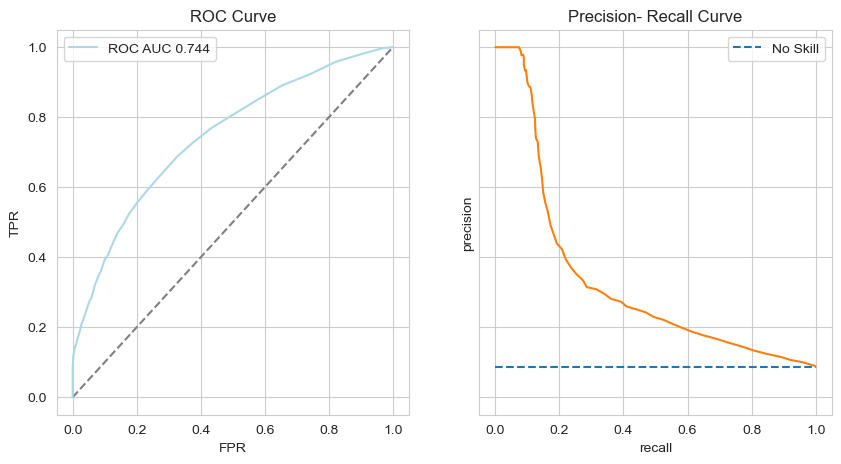

In [109]:
# Create experiment log
log = ExperimentLog()
# Create model log for random forest
rf_report = ModelLog(
    model=rf,
    X=X_validate[features].compute(),
    y=y_validate.compute(),
    label='RandomForest-Baseline'
)
#log experiment
log.record_experiment(rf_report)
log.model['RandomForest-Baseline'].print_report()

# Balanced Random Forest

In [59]:
from dask_ml.model_selection import GridSearchCV as daskGridSearch
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer

# Make a scorer using cohens_kappa
kappa_scorer = make_scorer(cohen_kappa_score)

param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [6, 8, 10, 12, 14, 16],
    'sampling_strategy':[.2, .4, .5, .6]
}
brf = BalancedRandomForestClassifier(random_state=0, criterion='gini')
cv = StratifiedKFold(n_splits=5)
brfcv = daskGridSearch(estimator=brf, param_grid=param_grid, cv= cv, scoring=kappa_scorer, n_jobs=-1)
brfcv.fit(X_train[features].values.compute(), y_train.values.compute().ravel())

print("Best Score: ", brfcv.best_score_)
print("Best params: ", brfcv.best_params_)

Best Score:  0.21679496538338094
Best params:  {'max_depth': 16, 'n_estimators': 500, 'sampling_strategy': 0.5}


           Balanced-Random-Forest-All
accuracy                     0.843541
precision                    0.253521
recall                       0.408318
f1                           0.312817
kappa                        0.229949
roc                          0.750779


              precision    recall  f1-score   support

           0       0.94      0.89      0.91     11073
           1       0.25      0.41      0.31      1058

    accuracy                           0.84     12131
   macro avg       0.60      0.65      0.61     12131
weighted avg       0.88      0.84      0.86     12131



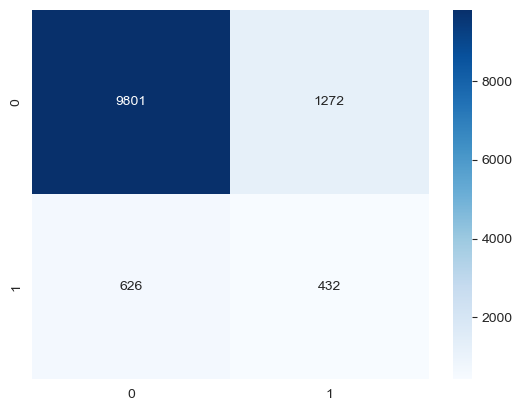

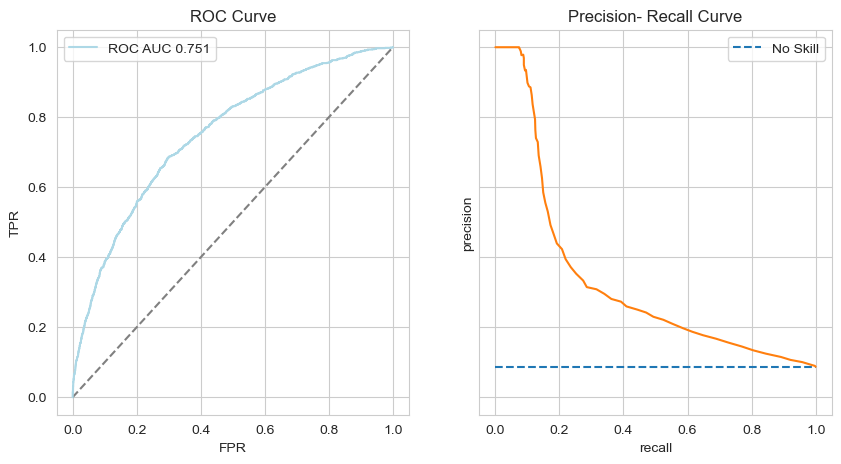

In [110]:
brf_report = ModelLog(
    model=brfcv,
    X=X_validate[features].compute(),
    y=y_validate.compute(),
    label='Balanced-Random-Forest-All'
)
#log experiment
log.record_experiment(brf_report)
log.model['Balanced-Random-Forest-All'].print_report()

# XGBoost

In [86]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

param_grid = {
    'scale_pos_weight': [1, 10, 25, 50, 75, 99, 100],
    'max_depth': [2, 4, 6, 8, 10, 12],
    'n_estimators': [100, 250, 500],
    'learning_rate': [0.1, 0.01, 0.05]
}

xgb_clf = xgb.XGBClassifier()
cv = StratifiedKFold(n_splits=5)
xgbcv = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, cv= cv, scoring=kappa_scorer, n_jobs=-1)
# with joblib.parallel_backend('dask'): <- Dask backend causes errors
xgbcv.fit(X_train[features].values.compute(), y_train.values.compute().ravel())

print("Best Score: ", xgbcv.best_score_)
print("Best params: ", xgbcv.best_params_)

Best Score:  0.20055289466249362
Best params:  {'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 500, 'scale_pos_weight': 10}


            XGB-All
accuracy   0.863985
precision  0.274734
recall     0.341210
f1         0.304384
kappa      0.229980
roc        0.723190


              precision    recall  f1-score   support

           0       0.94      0.91      0.92     11073
           1       0.27      0.34      0.30      1058

    accuracy                           0.86     12131
   macro avg       0.61      0.63      0.61     12131
weighted avg       0.88      0.86      0.87     12131



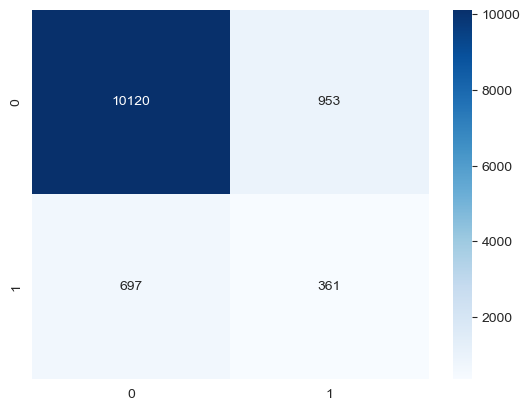

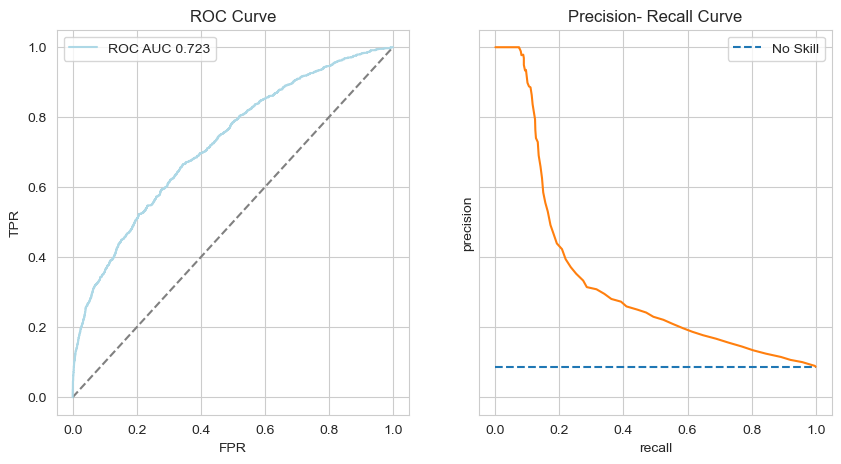

In [111]:
xgb_report = ModelLog(
    model=xgbcv,
    X=X_validate[features].compute(),
    y=y_validate.compute(),
    label='XGB-All'
)
#log experiment
log.record_experiment(xgb_report)
log.model['XGB-All'].print_report()

In [ ]:
cluster_profiles = train_subset[numeric_cols].compute()
cluster_profiles['cluster'] = km.labels_
cluster_profiles['cluster'] = cluster_profiles['cluster'].astype(str)

# Feature Engineeering
* Split
* All Variable Exploration
* Correlation of Features
* Kmean clustering